In [1]:
# Install the here package (if haven't already)
if (!requireNamespace("here", quietly = TRUE)) {
  install.packages("here")
}

library(here)
source(here("WL_helperfuncs.r"), encoding = "UTF-8")

here() starts at C:/Users/mwiseman/Desktop/Micaela rTMS Project/Winterlight_GH



Load and clean data

In [2]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv"))
WL_2 <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMSremote_2024_03_28.csv"))

# Apply filters
WL <- WL[grep("^(TMS|MDD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"


# Combine datasets
common_columns <- intersect(names(WL), names(WL_2))
WL_common <- WL[, common_columns]
WL_2_common <- WL_2[, common_columns]
WL_combined <- rbind(WL_common, WL_2_common)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD|MFB)", WL_combined$participant_external_id), "MDD", NA)
  )
)

## Remove participants with high QIDS
WL_combined <- WL_combined[WL_combined$participant_external_id != "CTC036" &
                          WL_combined$participant_external_id != "CTC004" &
                          WL_combined$participant_external_id != "CTC006" &
                          WL_combined$participant_external_id != "CTC017" &
                          WL_combined$participant_external_id != "CTC030" &
                          WL_combined$participant_external_id != "CTC039" &
                          WL_combined$participant_external_id != "CTC043" &
                          WL_combined$participant_external_id != "CTC045" &
                          WL_combined$participant_external_id != "CTC053" &
                          WL_combined$participant_external_id != "CTC052" &
                          WL_combined$participant_external_id != "CTC058" &
                          WL_combined$participant_external_id != "CTC058_new" &
                          WL_combined$participant_external_id != "CTC023" &
                          WL_combined$participant_external_id != "CTB001" &
                          WL_combined$participant_external_id != "CTC063" &
                          WL_combined$participant_external_id != "CTC076" , ]

# Define remote participants and assign testing location
remote_participants <- c(
    "CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030",
    "CTC034", "CTC036", "CTC045", "TMS038")

# Function to identify CTC046 and higher
is_ctc046_or_higher <- function(id) {
  if (grepl("^CTC", id)) {
    # Extract the numeric part of the ID and check if it is 46 or higher
    num_part <- as.numeric(sub("^CTC", "", id))
    return(num_part >= 46)
  }
  FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
ctc046_or_higher <- sapply(WL_combined$participant_external_id, is_ctc046_or_higher)
additional_ctc <- WL_combined$participant_external_id[ctc046_or_higher]

# Function to identify TMS040 and higher
is_tms040_or_higher <- function(id) {
    if (grepl("^TMS", id)) {
        # Extract the numeric part of the ID and check if it is 46 or higher
        num_part <- as.numeric(sub("^TMS", "", id))
        return(num_part >= 40)
    }
    FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
tms040_or_higher <- sapply(WL_combined$participant_external_id, is_tms040_or_higher)
additional_tms <- WL_combined$participant_external_id[tms040_or_higher]

remote_participants <- c(remote_participants, additional_ctc, additional_tms)

WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% c("TMS052", "TMS053"), 
                                       "remote", WL_combined$testing_location)


# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

# Read and process demographic data
demoMDD <- demo_read_and_process(1)
demoCTRL <- demo_read_and_process(2)

# Generate new column names
column_mapping <- setNames(
    # Old names
  c(paste0(rep(c("bl_", "2wk_", "4wk_"), each = 1), "qids_tot"),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 16), "qids_sr_", 1:16),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_", 1:8),
    paste0(rep(c("bl_", "2wk_", "4wk_"), each = 8), "gad7_tot")),
  # New names
  c(paste0("qids_total_", c("pre", "wk2", "wk4")),
    paste0("qids_", 1:16, "_", rep(c("pre", "wk2", "wk4"), each = 16)),
    paste0("gad7_", 1:8, "_", rep(c("pre", "wk2", "wk4"), each = 8)),
    paste0("gad7_total_", rep(c("pre", "wk2", "wk4"), each = 8)))
)

# Remove leading and trailing whitespaces from column names in demoCTRL
demoCTRL <- demoCTRL %>%
  rename_all(~trimws(.))

# Rename columns in demoCTRL
demoCTRL <- demoCTRL %>% rename(!!!column_mapping)

# Combine demographic datasets
demoMDD$dob_yr <- as.numeric(demoMDD$dob_yr)
demoCTRL$dob_yr <- as.numeric(demoCTRL$dob_yr)
demoMDD$handedness <- as.numeric(as.character(demoMDD$handedness))
demoCTRL$handedness <- as.numeric(as.character(demoCTRL$handedness))

demoALL <- bind_rows(demoMDD, demoCTRL)

# Merge relevant columns from demoALL into WL

WL_demo <- WL_combined %>% left_join(demoALL %>% select(participant_external_id, sex,
                                          age_screening,
                                          years_education,
                                          age_learned_english,
                                          first_language_english,
                                          starts_with("qids"),
                                          starts_with("gad7")))

# Read in psychiatry data
psych <- read_csv(here("Final_Consolidated_Psychiatry_Data.csv"))

# Filter to match participant IDs in WL_demo
psych_filtered <- psych %>%
  filter(participant_external_id %in% WL_demo$participant_external_id)

# Merge the datasets based on "participant_external_id" and retain all columns
# Use full_join to include all participants from both datasets
WL_demo_psych <- full_join(psych_filtered %>% select(participant_external_id,
                                              starts_with("hamd17"),
                                              starts_with("qids"),
                                              starts_with("gad7")),
                           WL_demo,
                           by = "participant_external_id",
                           suffix = c("", ".psych"))

# Identify common columns (excluding "participant_external_id")
common_columns <- setdiff(intersect(names(WL_demo), names(psych_filtered)), "participant_external_id")

# Update NA values in WL_demo columns with values from psych where applicable
WL_demo_psych <- WL_demo_psych %>%
  mutate(across(all_of(common_columns), 
  ~ifelse(is.na(.), get(paste0(cur_column(), ".psych")), .)))

# Optionally, remove the extra columns if they are no longer needed
WL_demo_psych <- select(WL_demo_psych, -ends_with(".psych"))

# Check the structure of the final dataframe

write.csv(WL_demo_psych, here("WL_demo_psych.csv"), row.names = FALSE)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Joining with `by = join_by(participant_external_id)`
Rows: 73 Columns: 957
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (60): participant_external_id, demog_household_members, prtms_workstat_...
dbl (786): demog_gender, demog_sex, demog_age, demog_married, demog_children...
lgl (111): demog_gender_other, demog_sex_other, tms_details_ineligibility, t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in full_join(psych_filtered %>% select(participant_external_id, :
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row

Subset by task (journalling) and visit (baseline)

In [3]:
# Subset to look at journaling and baseline scores
WL_full_jou <-subset_by_task(WL_demo_psych, "journaling")
WL_full_jou_bl<-subset_by_visit(WL_full_jou, "V1")

str(WL_full_jou_bl)

tibble [164 × 1,146] (S3: tbl_df/tbl/data.frame)
 $ participant_external_id                                    : chr [1:164] "MDD103" "MDD103" "MDD104" "MDD104" ...
 $ hamd17_1_pre                                               : num [1:164] 3 3 3 3 3 3 3 3 NA NA ...
 $ hamd17_2_pre                                               : num [1:164] 2 2 2 2 3 3 2 2 NA NA ...
 $ hamd17_3_pre                                               : num [1:164] 3 3 3 3 2 2 3 3 NA NA ...
 $ hamd17_4_pre                                               : num [1:164] 2 2 2 2 2 2 0 0 NA NA ...
 $ hamd17_5_pre                                               : num [1:164] 0 0 0 0 1 1 0 0 NA NA ...
 $ hamd17_6_pre                                               : num [1:164] 0 0 0 0 2 2 0 0 NA NA ...
 $ hamd17_7_pre                                               : num [1:164] 4 4 4 4 2 2 2 2 NA NA ...
 $ hamd17_8_pre                                               : num [1:164] 0 0 0 0 0 0 2 2 NA NA ...
 $ hamd17_9_pre    

Narrow down target demographic and speech variables and check missing 

In [4]:
# Categorizing variables into Clinical, Demographic, and Speech variables
demographic_variables <- c('sex', 'age_screening', 'participant_group', 'age_learned_english', 'testing_location','years_education',"first_language_english")
speech_variables <- c('fundamental_frequency_mean','fundamental_frequency_variance', 'intensity_mean_db','medium_pause_duration',
                    'speech_rate', 'sentiment_dominance', 'sentiment_valence',
                    'sentiment_arousal')

# Creating subsets of data based on these categories
clinical_data <- WL_full_jou_bl[, c("participant_external_id", "hamd17_total_pre", "qids_total_pre")]
demographic_data <- WL_full_jou_bl[, c("participant_external_id", demographic_variables)]
speech_data <- WL_full_jou_bl[, c("participant_external_id", speech_variables)]

speech_missing <- analyze_missing_data(speech_data, "participant_external_id")
write.csv(speech_missing, "speech_missing.csv")


# For clinical data
clinical_missing <- analyze_missing_data(clinical_data, "participant_external_id")
write.csv(clinical_missing, "clinical_missing.csv")
## need hamds for TMS035, TMS052, TMS054, TMS053, TMS055, TMS056, TMS058, TMS059, TMS057, MFB14

# For demographic data
demographic_missing <- analyze_missing_data(demographic_data, "participant_external_id")
write.csv(demographic_missing, "demographic_missing.csv")

Looking at total duration audio and total words 

Total duration audio

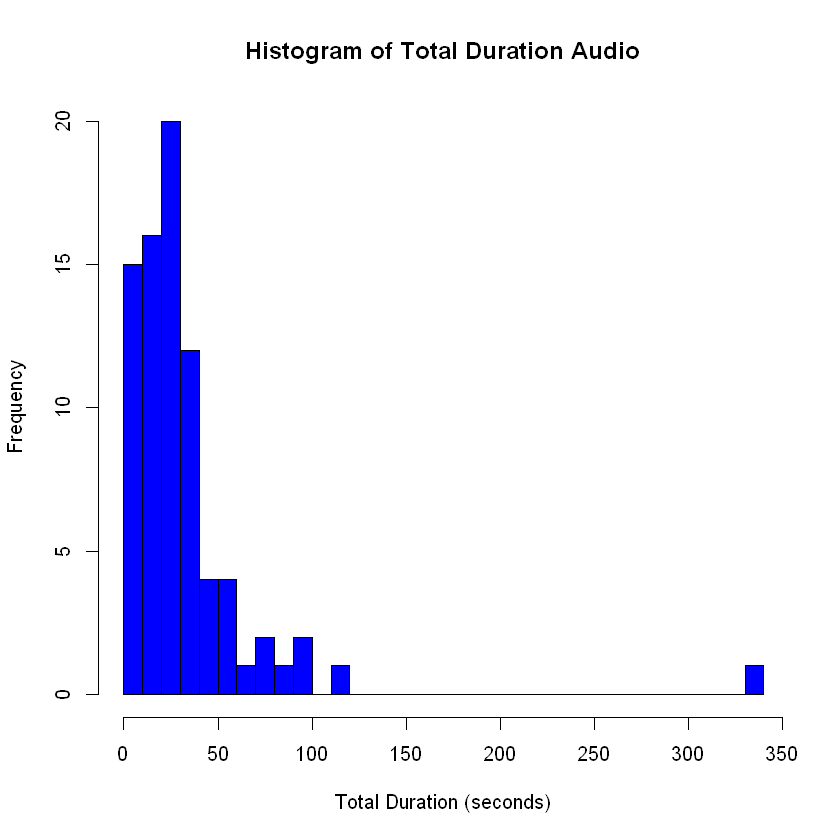

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.61   12.54   22.76   31.92   33.67  336.10 
[1] "Outliers:  8"
[1] 336.10  69.80 110.70  95.01  84.81  73.67  90.95  71.65


participant_external_id,total_duration_audio,stimulus_filename
<chr>,<dbl>,<chr>
TMS004,9.20,en_instruction_journal_feeling.mp3
TMS005,6.98,en_instruction_journal_feeling.mp3
TMS011,11.77,en_instruction_journal_feeling.mp3
TMS013,3.16,en_instruction_journal_feeling.mp3
TMS016,6.75,en_instruction_journal_feeling.mp3
TMS026,10.01,en_instruction_journal_feeling.mp3
TMS030,6.72,en_instruction_journal_feeling.mp3
TMS040,10.71,en_instruction_journal_feeling.mp3
TMS050,2.35,en_instruction_journal_feeling.mp3


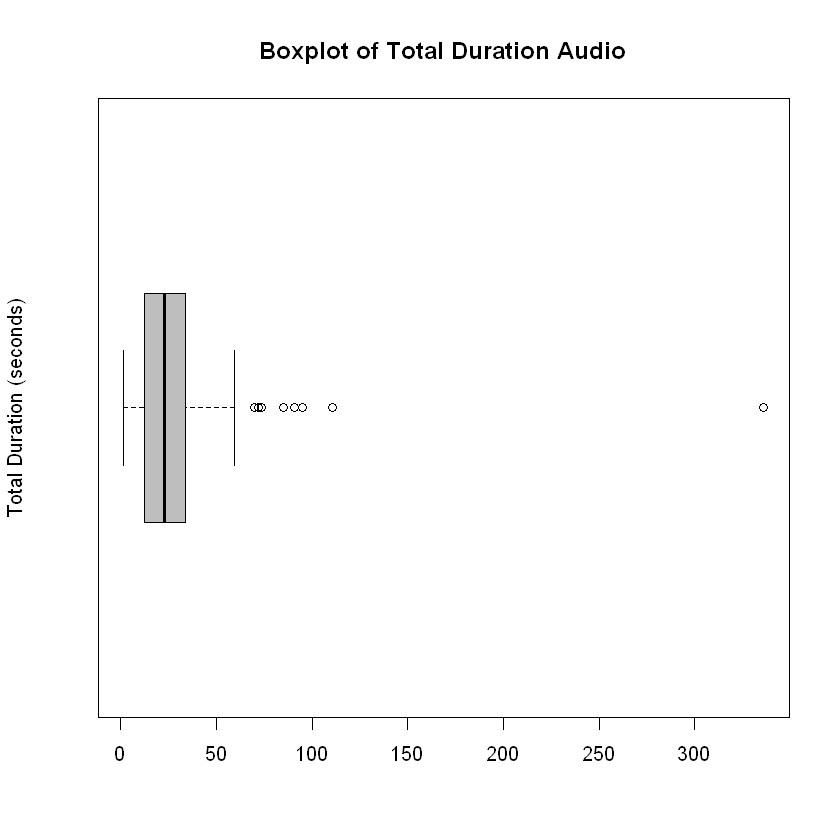

In [22]:
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

# Create a histogram and a boxplot excluding NA values
hist(WL_jou_bl_feeling$total_duration_audio, main="Histogram of Total Duration Audio", xlab="Total Duration (seconds)", col="blue", breaks=30)
boxplot(WL_jou_bl_feeling$total_duration_audio, main="Boxplot of Total Duration Audio", ylab="Total Duration (seconds)", horizontal=TRUE, col="grey", na.rm=TRUE)

# Basic summary statistics with NA removal
summary_stats <- summary(WL_jou_bl_feeling$total_duration_audio, na.rm = TRUE)
print(summary_stats)

# Calculate IQR and identify outliers with NA removal
IQR_value <- IQR(WL_jou_bl_feeling$total_duration_audio, na.rm = TRUE)
Q1 <- quantile(WL_jou_bl_feeling$total_duration_audio, 0.25, na.rm = TRUE)
Q3 <- quantile(WL_jou_bl_feeling$total_duration_audio, 0.75, na.rm = TRUE)
outlier_threshold_low <- Q1 - 1.5 * IQR_value
outlier_threshold_high <- Q3 + 1.5 * IQR_value

# Identify and print outliers
outliers_indices <- which(WL_jou_bl_feeling$total_duration_audio < outlier_threshold_low | WL_jou_bl_feeling$total_duration_audio > outlier_threshold_high, arr.ind = TRUE)
outliers_values <- WL_jou_bl_feeling$total_duration_audio[outliers_indices]
print(paste("Outliers: ", length(outliers_values)))
print(outliers_values)


# Calculate Q1 for total_duration_audio
Q1 <- quantile(WL_jou_bl_feeling$total_duration_audio, 0.25, na.rm = TRUE)

# Subset the DataFrame to include only those rows where total_duration_audio is below Q1
below_Q1_df <- WL_jou_bl_feeling[WL_jou_bl_feeling$total_duration_audio < Q1, c("participant_external_id", "total_duration_audio", "stimulus_filename")]

# Print the resulting DataFrame
below_Q1_df

Total words

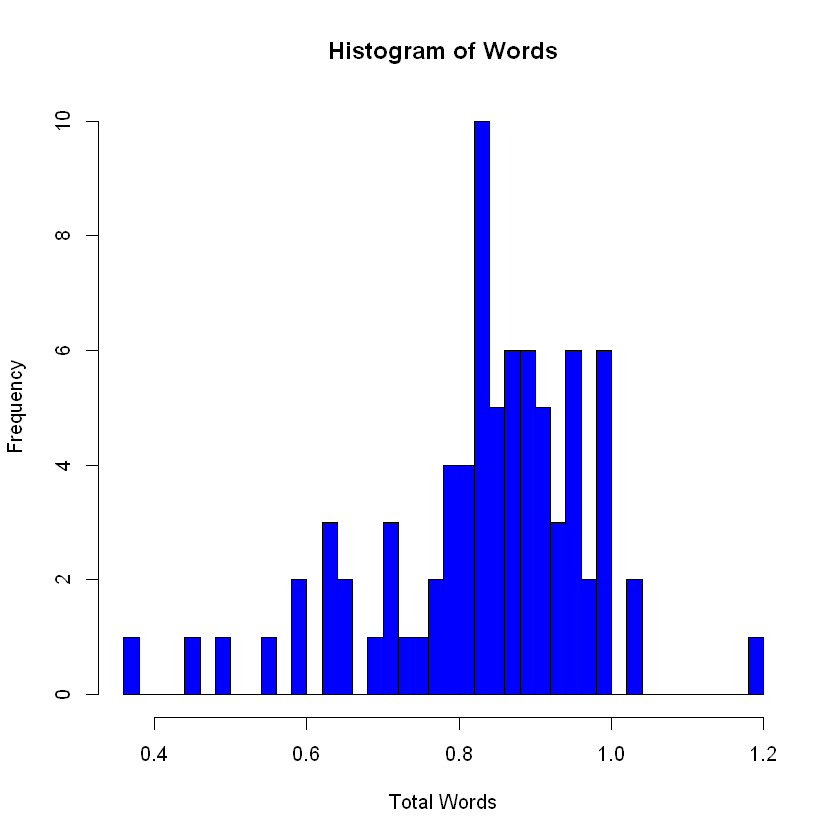

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3636  0.7877  0.8500  0.8323  0.9206  1.2000 
[1] "Outliers:  7"
[1] 0.5833333 0.5000000 0.3636364 0.4444444 0.5833333 0.5476190 1.2000000


participant_external_id,total_words,stimulus_filename
<chr>,<dbl>,<chr>
TMS001,0.7241379,en_instruction_journal_feeling.mp3
TMS005,0.5833333,en_instruction_journal_feeling.mp3
TMS011,0.6470588,en_instruction_journal_feeling.mp3
TMS014,0.7058824,en_instruction_journal_feeling.mp3
TMS019,0.5000000,en_instruction_journal_feeling.mp3
TMS020,0.3636364,en_instruction_journal_feeling.mp3
TMS022,0.6363636,en_instruction_journal_feeling.mp3
TMS024,0.7500000,en_instruction_journal_feeling.mp3
TMS029,0.6500000,en_instruction_journal_feeling.mp3


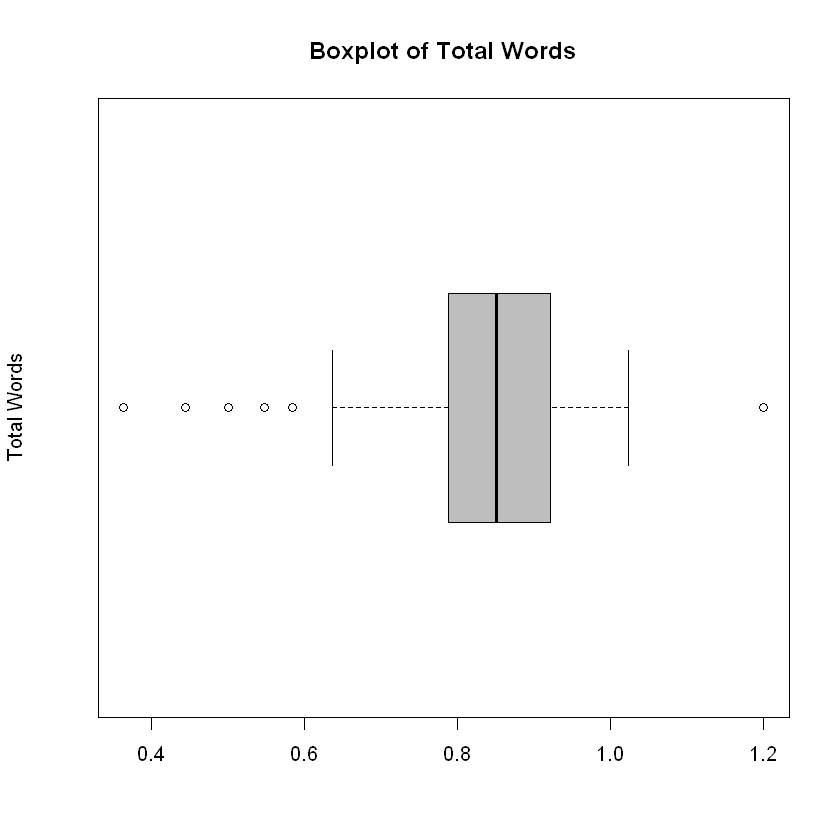

In [48]:
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

# Create a histogram and a boxplot excluding NA values
hist(WL_jou_bl_feeling$total_words, main="Histogram of Words", xlab="Total Words", col="blue", breaks=30)
boxplot(WL_jou_bl_feeling$total_words, main="Boxplot of Total Words", ylab="Total Words", horizontal=TRUE, col="grey", na.rm=TRUE)

# Basic summary statistics with NA removal
summary_stats_totwords <- summary(WL_jou_bl_feeling$total_words, na.rm = TRUE)
print(summary_stats_totwords)

# Calculate IQR and identify outliers with NA removal
IQR_value_totwords <- IQR(WL_jou_bl_feeling$total_words, na.rm = TRUE)
Q1_tot_wds <- quantile(WL_jou_bl_feeling$total_words, 0.25, na.rm = TRUE)
Q3_tot_wds <- quantile(WL_jou_bl_feeling$total_words, 0.75, na.rm = TRUE)
outlier_threshold_low_tot_wds <- Q1_tot_wds - 1.5 * IQR_value_totwords
outlier_threshold_high_tot_wds <- Q3 + 1.5 * IQR_value_totwords

# Identify and print outliers
outliers_indices_tot_wds <- which(WL_jou_bl_feeling$total_words < outlier_threshold_low_tot_wds | WL_jou_bl_feeling$total_words > outlier_threshold_high_tot_wds, arr.ind = TRUE)
outliers_values_tot_wds <- WL_jou_bl_feeling$total_words[outliers_indices_tot_wds]
print(paste("Outliers: ", length(outliers_values_tot_wds)))
print(outliers_values)

# Subset the DataFrame to include only those rows where total_words is below Q1
below_Q1_df_tot_wds <- WL_jou_bl_feeling[WL_jou_bl_feeling$total_words < Q1_tot_wds, c("participant_external_id", "total_words", "stimulus_filename")]

# Print the resulting DataFrame
below_Q1_df_tot_wds

Removing participants with processing errors - no baseline speech info 

In [24]:
WL_full_jou_bl <- WL_full_jou_bl[WL_full_jou_bl$participant_external_id != "TMS055" &
                                 WL_full_jou_bl$participant_external_id != "TMS053" &
                                 WL_full_jou_bl$participant_external_id != "MFB14", ]

Linear models in MDD patients (with interaction term)

In [15]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("lmtest")

library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

results <- list()
plots <- list()

# Create a directory for the plots
plots_directory <- "~/PhD/Thesis/Plots/"
if (!dir.exists(plots_directory)) {
    dir.create(plots_directory)
}

for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression with interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "* sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre interaction", sep = "_")]] <- model_summary
    
    # Create a plot
    plot_name <- paste(s," hamd17_total_pre interaction_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre", color = "sex")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE, 
                    aes_string(group = "sex", color = "sex")) + 
    labs(title = paste(s, "X", "hamd17_total_pre", sep = " "),
         x = s, y = "hamd17_total_pre") +
    theme_minimal() +
    theme(plot.title = element_text(size = 17)) # smaller title

  # Save the plot
  file_name <- paste(plots_directory, "/", plot_name, ".png", sep = "")
}

print(plots)
print(results)


Warning message:
"package 'dplyr' is in use and will not be installed"
Warning message:
"package 'ggplot2' is in use and will not be installed"
Warning message:
"package 'lmtest' is in use and will not be installed"


Warning message in dir.create(plots_directory):
"cannot create dir 'C:\Users\mwiseman\Documents\PhD\Thesis\Plots', reason 'No such file or directory'"


list()
$`fundamental_frequency_mean_hamd17_total_pre interaction`

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0421 -3.3555 -0.2433  2.4329 11.7503 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                     11.66727    4.98840   2.339  0.02355 * 
fundamental_frequency_mean       0.06236    0.02548   2.447  0.01812 * 
sexM                            17.85552    6.13617   2.910  0.00547 **
age_screening                   -0.01414    0.04339  -0.326  0.74592   
age_learned_english              0.06099    0.11371   0.536  0.59417   
fundamental_frequency_mean:sexM -0.13965    0.04497  -3.106  0.00318 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.14 on 48 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.2537,	Adjusted R-squared:  0.176 
F-statistic: 3.264 on 5 and 48 DF,  p-value:

Linear models in MDD patients without interaction term

In [12]:
library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")


results <- list()
plots <- list()
stats_df <- data.frame()  # Dataframe to store statistics
p_values_lms <- c()  # Vector to collect p-values


for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression without interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "+ sex + age_screening + age_learned_english"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre", sep = "_")]] <- model_summary
    
    # Extract coefficients and p-values
    coefs <- summary(model)$coefficients
    p_values_lms<- c(p_values_lms, coefs[2, "Pr(>|t|)"])  # Collect p-values
    
    # Create a summary stats row
    stats_row <- data.frame(variable = s, 
                            estimate = coefs[2, "Estimate"], 
                            std_error = coefs[2, "Std. Error"], 
                            statistic = coefs[2, "t value"], 
                            p_value = coefs[2, "Pr(>|t|)"])
    stats_df <- rbind(stats_df, stats_row)  # Append to the stats dataframe

    # Create and save plots
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE) + 
        labs(title = paste(s, "vs", "hamd17_total_pre"),
             x = s, y = "hamd17_total_pre") +
        theme_minimal() +
        theme(plot.title = element_text(size = 17))


    plot_name <- paste(s, "hamd17_total_pre_plot", ".png", sep = "")
    ggsave(plot_name, plot, width = 6, height = 4, bg = "white")
}

# Print and save results
print(plots)
print(results)
write.csv(stats_df, "stats_df.csv", row.names = FALSE)



Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$fundamental_frequency_mean_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1053 -3.2058 -0.4062  1.8096 10.9373 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                20.86478    4.42415   4.716 2.55e-05 ***
fundamental_frequency_mean  0.01640    0.02394   0.685    0.497    
sexM                        0.58167    1.85733   0.313    0.756    
age_screening              -0.05739    0.04571  -1.255    0.216    
age_learned_english         0.07687    0.12184   0.631    0.531    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.409 on 43 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.05446,	Adjusted R-squared:  -0.0335 
F-statistic: 0.6192 on 4 and 43 DF,  p-value: 0.6513


$fundamental_frequency_variance_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_d

LM Controlling for education

In [13]:
library(dplyr)
library(ggplot2)
library(lmtest)

WL_full_jou_bl$sex <- as.factor(WL_full_jou_bl$sex)
WL_full_jou_bl$testing_location <- as.factor(WL_full_jou_bl$testing_location)
WL_jou_bl_MDD <- WL_full_jou_bl %>% filter(participant_group == "MDD")
WL_jou_bl_MDD_feeling <- WL_jou_bl_MDD %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")


results <- list()
plots <- list()
stats_df <- data.frame()  # Dataframe to store statistics
p_values_lms <- c()  # Vector to collect p-values


for (s in speech_variables) {
    # Filter out observations where sex is NA
    filtered_data <- WL_jou_bl_MDD_feeling %>%
        filter(!is.na(sex), !is.na(!!as.symbol(s)), !is.na(hamd17_total_pre))
    
    # Linear regression without interaction term
    formula <- as.formula(paste("hamd17_total_pre ~", s, "+ sex + age_screening + age_learned_english + years_education"))
    model <- lm(formula, data = filtered_data)
    
    # Model summary
    model_summary <- summary(model)
    
    # Store the summary result
    results[[paste(s, "hamd17_total_pre", sep = "_")]] <- model_summary
    
    # Extract coefficients and p-values
    coefs <- summary(model)$coefficients
    p_values_lms<- c(p_values_lms, coefs[2, "Pr(>|t|)"])  # Collect p-values
    
    # Create a summary stats row
    stats_row <- data.frame(variable = s, 
                            estimate = coefs[2, "Estimate"], 
                            std_error = coefs[2, "Std. Error"], 
                            statistic = coefs[2, "t value"], 
                            p_value = coefs[2, "Pr(>|t|)"])
    stats_df <- rbind(stats_df, stats_row)  # Append to the stats dataframe

    # Create and save plots
    plot <- ggplot(filtered_data, aes_string(x = s, y = "hamd17_total_pre")) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE) + 
        labs(title = paste(s, "vs", "hamd17_total_pre"),
             x = s, y = "hamd17_total_pre") +
        theme_minimal() +
        theme(plot.title = element_text(size = 17))


    plot_name <- paste(s, "hamd17_total_pre_plot", ".png", sep = "")
    ggsave(plot_name, plot, width = 6, height = 4, bg = "white")
}

# Print and save results
print(plots)
print(results)
write.csv(stats_df, "stats_df.csv", row.names = FALSE)



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


list()
$fundamental_frequency_mean_hamd17_total_pre

Call:
lm(formula = formula, data = filtered_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7185 -2.7379 -0.6906  2.1458 11.7215 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                28.78878    5.65594   5.090 7.94e-06 ***
fundamental_frequency_mean  0.01318    0.02306   0.571   0.5709    
sexM                        0.26412    1.79195   0.147   0.8835    
age_screening              -0.02890    0.04595  -0.629   0.5327    
age_learned_english         0.08219    0.11717   0.701   0.4869    
years_education            -0.54995    0.25873  -2.126   0.0395 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.239 on 42 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.1463,	Adjusted R-squared:  0.04467 
F-statistic: 1.439 on 5 and 42 DF,  p-value: 0.2302


$fundamental_frequency_varian

Correction for multiple comparisons

In [ ]:
adjusted_p_values <- p.adjust(p_values_lms, method = "BH")
# Display the original and adjusted p-values
data.frame(Original_P_Value = p_values_lms, Adjusted_P_Value = adjusted_p_values)

Original_P_Value,Adjusted_P_Value
<dbl>,<dbl>
0.1560039,0.6532403
0.6255178,0.7148775
0.4899302,0.6532403
0.4318237,0.6532403
0.8165480,0.8165480
0.3362275,0.6532403
0.3016326,0.6532403
0.3183920,0.6532403


ANCOVAs by group controlling for sex

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


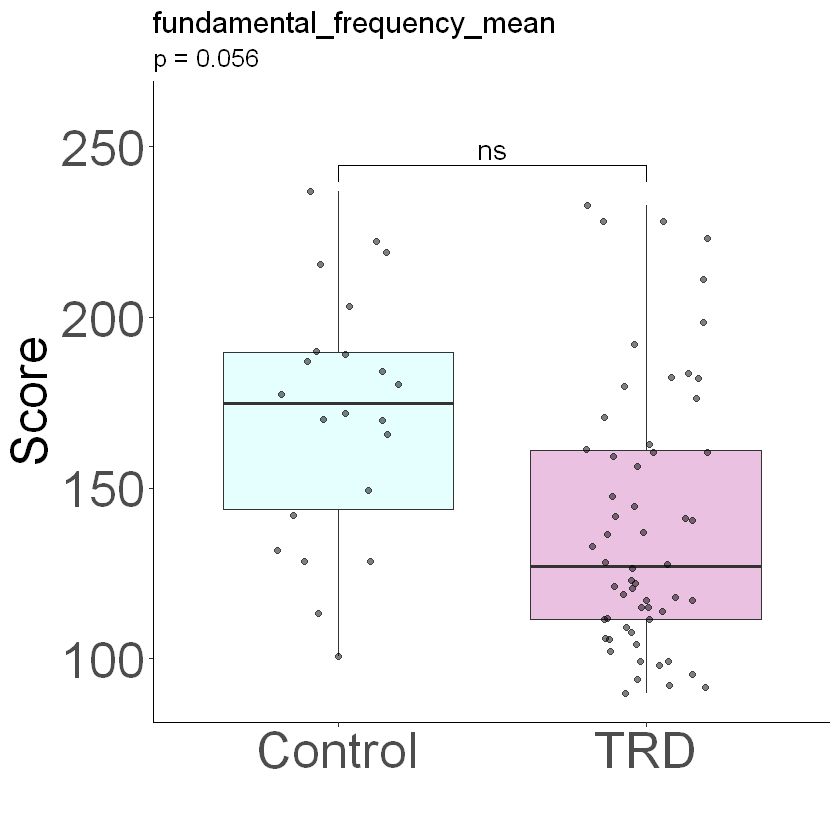

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


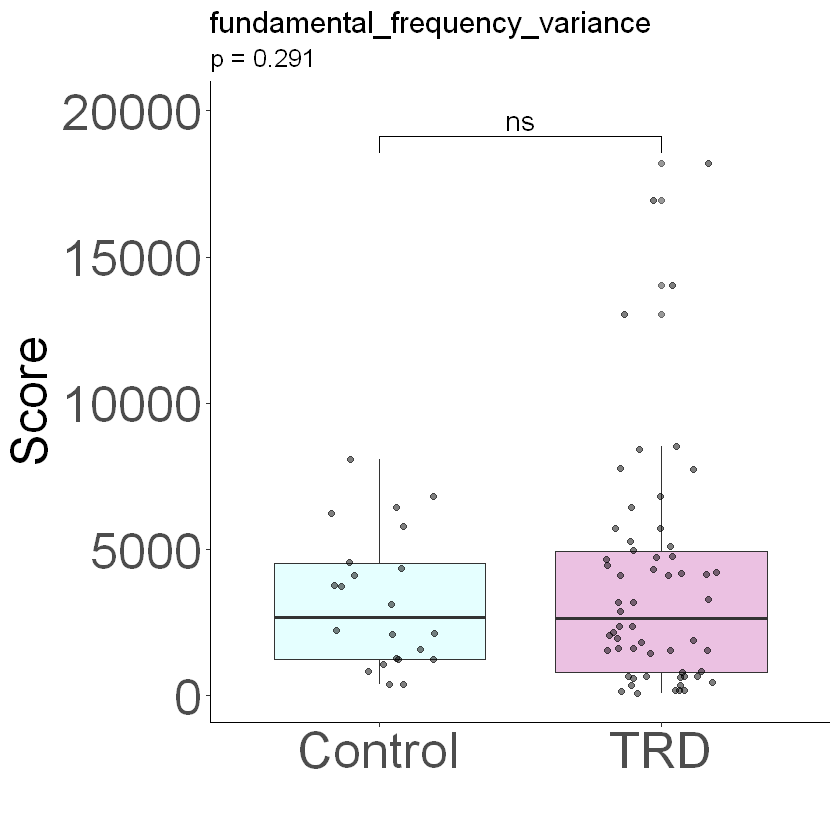

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


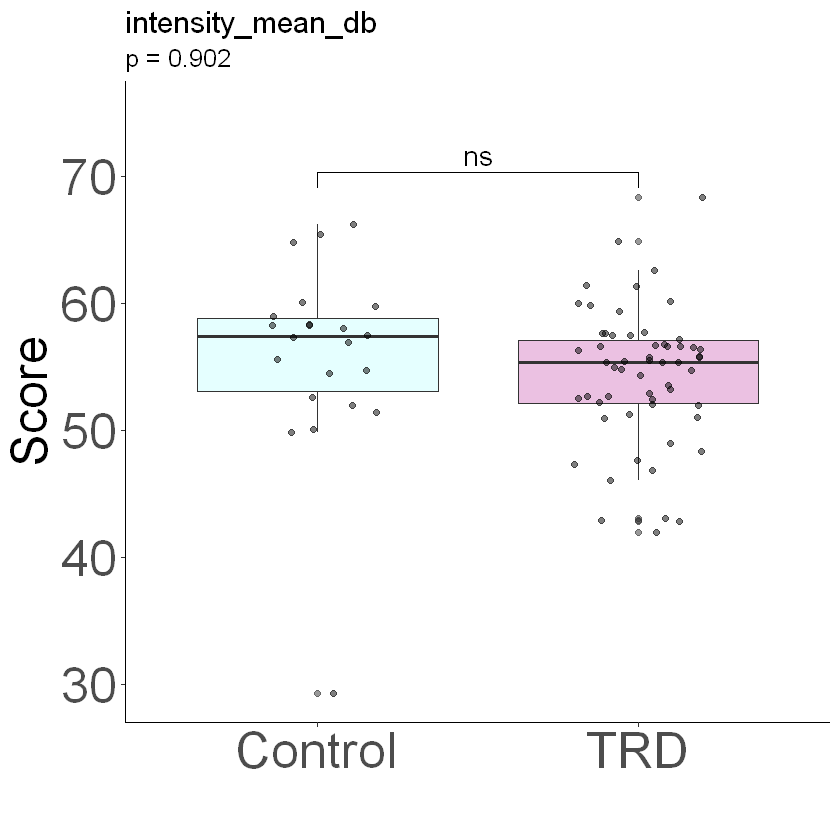

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


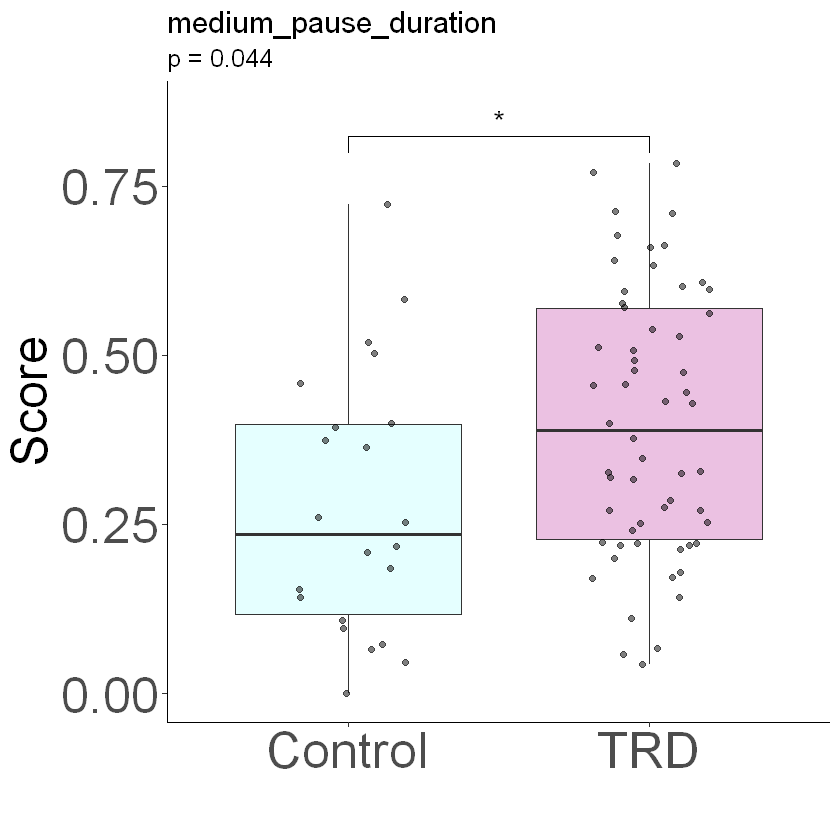

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


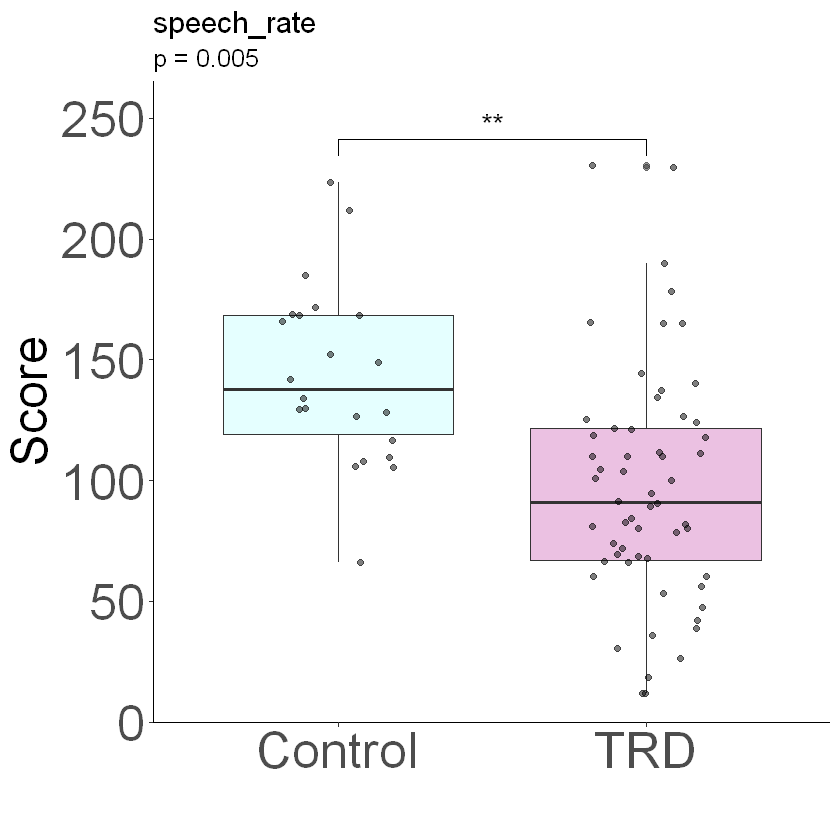

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


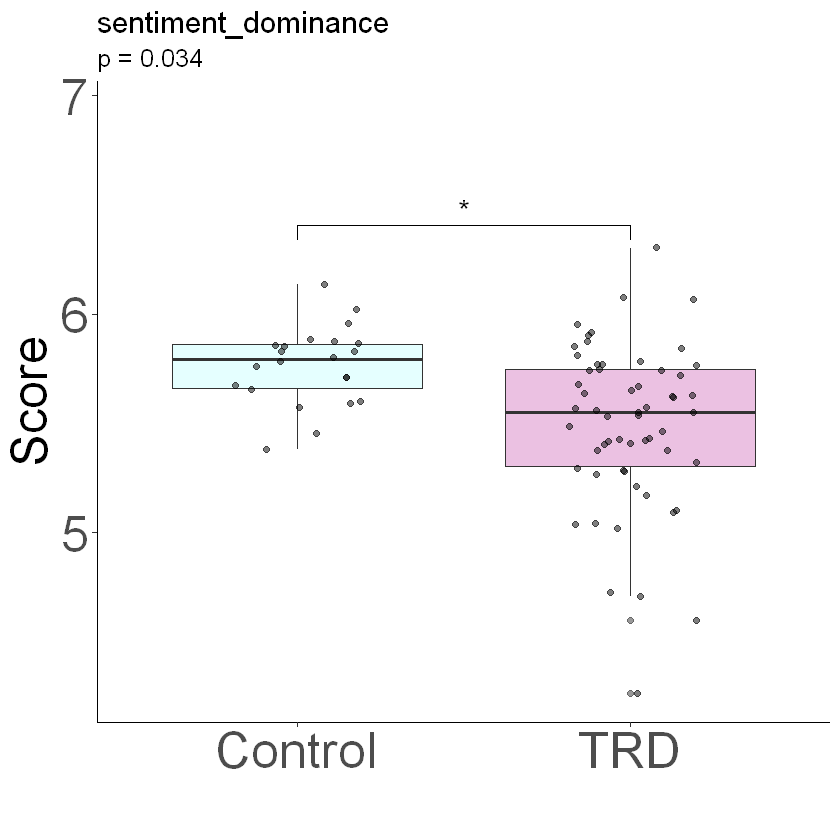

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


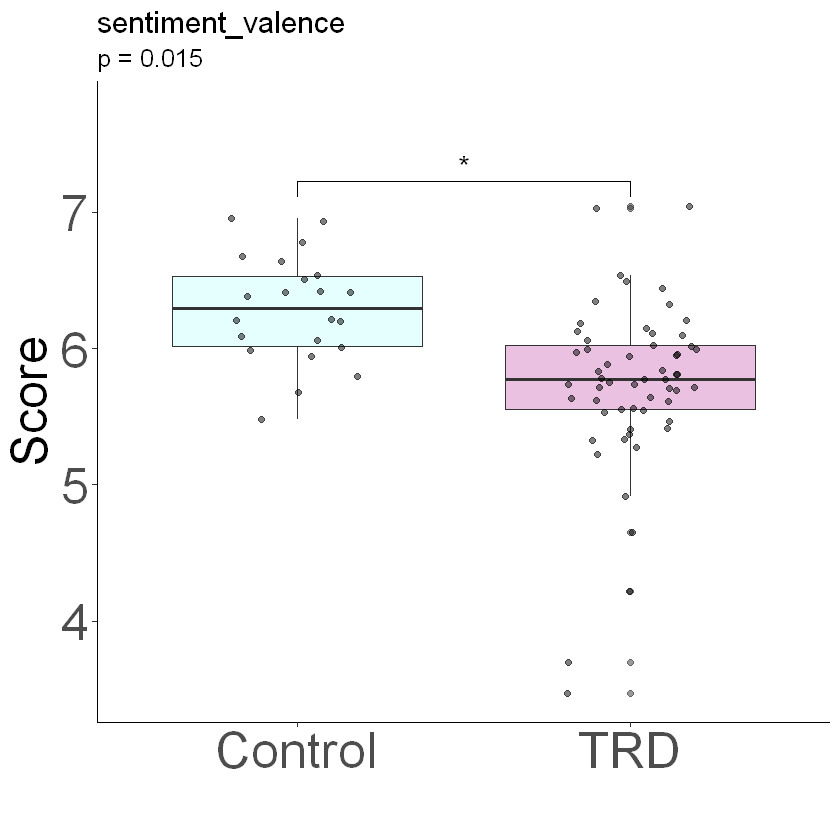

                        Variable    F_Value        Pr_F   Df
1     fundamental_frequency_mean 3.79768254 0.055852272 1/62
2 fundamental_frequency_variance 1.13418326 0.291014804 1/62
3              intensity_mean_db 0.01525498 0.902101954 1/62
4          medium_pause_duration 4.23170951 0.043888383 1/62
5                    speech_rate 8.50988042 0.004913549 1/62
6            sentiment_dominance 4.71253054 0.033780784 1/62
7              sentiment_valence 6.25426169 0.015046050 1/62
8              sentiment_arousal 5.71897129 0.019830319 1/62
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1        0.0577175729  139.3586281   38.8086944  171.6877246   36.7699026
2        0.0179646462 3835.2045400 3991.5414452 3248.1404111 2299.3665951
3        0.0002459876   54.3540631    5.3015429   55.8806789    7.4728731
4        0.0638925001    0.3991589    0.1964401    0.2782126    0.1962421
5        0.1206906092   96.6845948   48.4231440  143.9095138   37.2341350
6      

list()

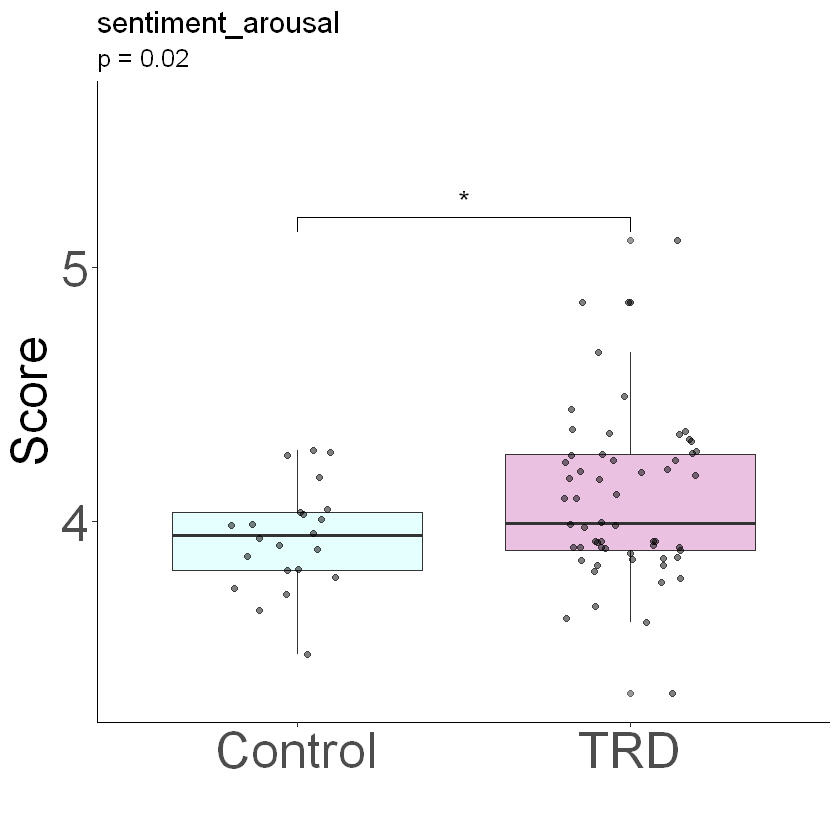

In [8]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()


# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[6]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[6]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


controlling for education 

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


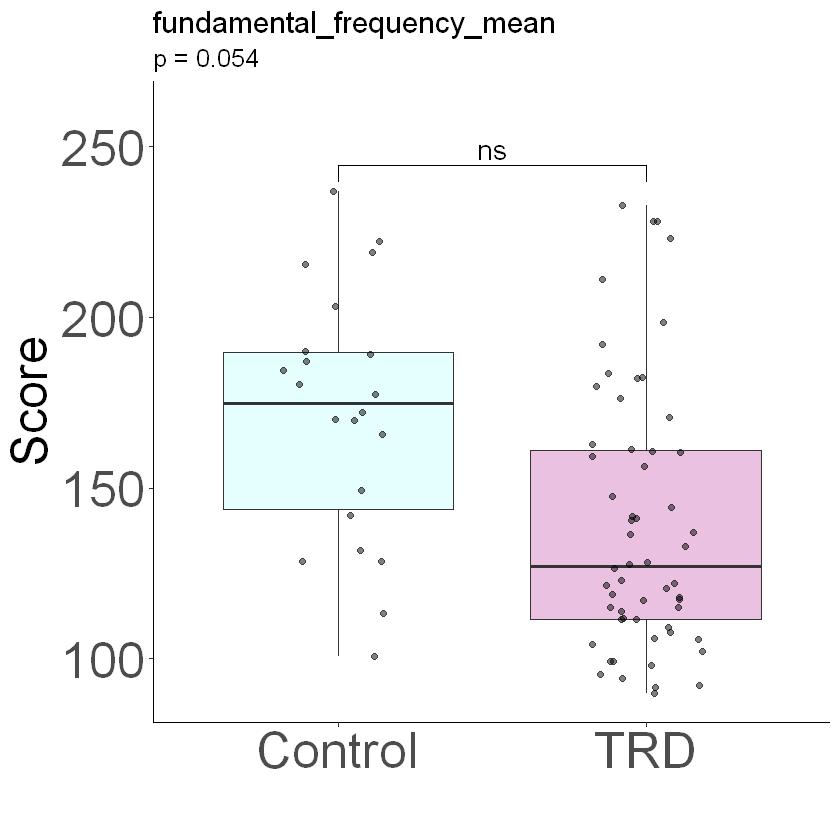

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


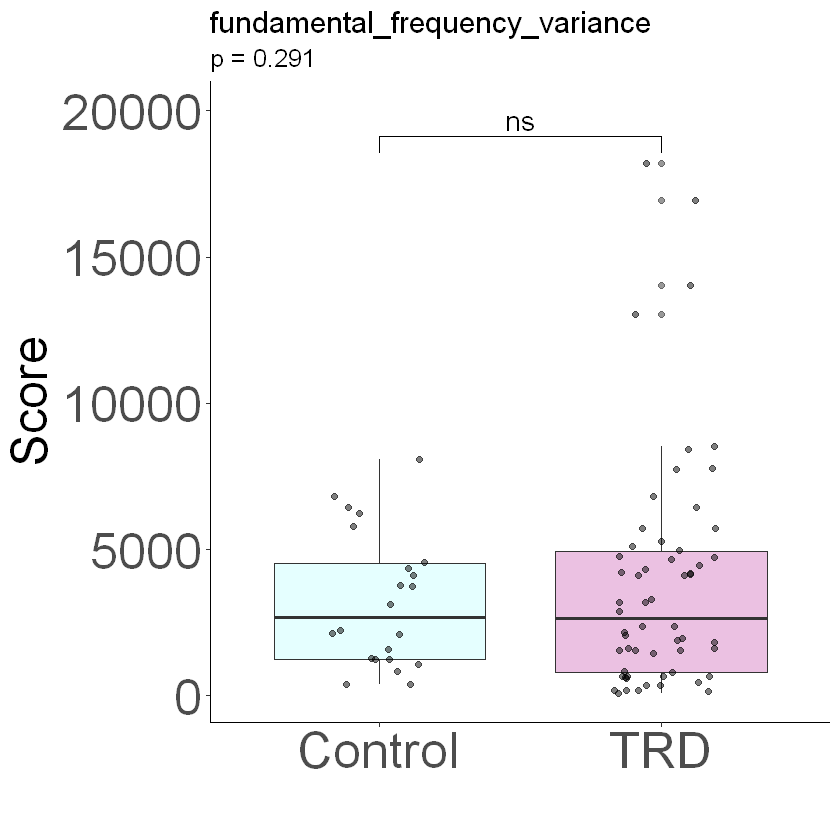

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


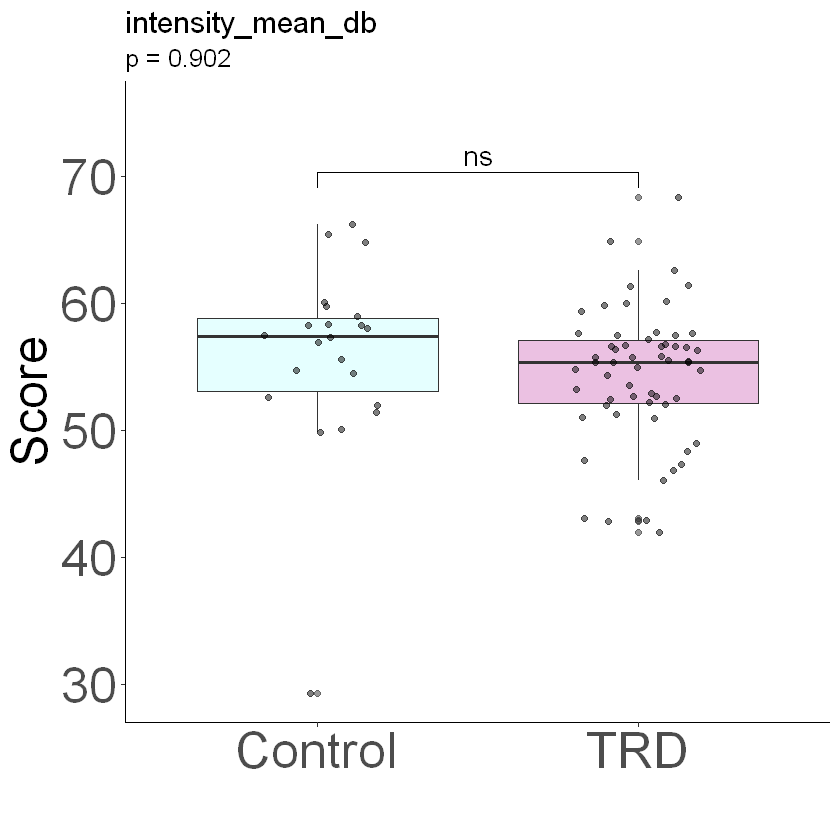

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


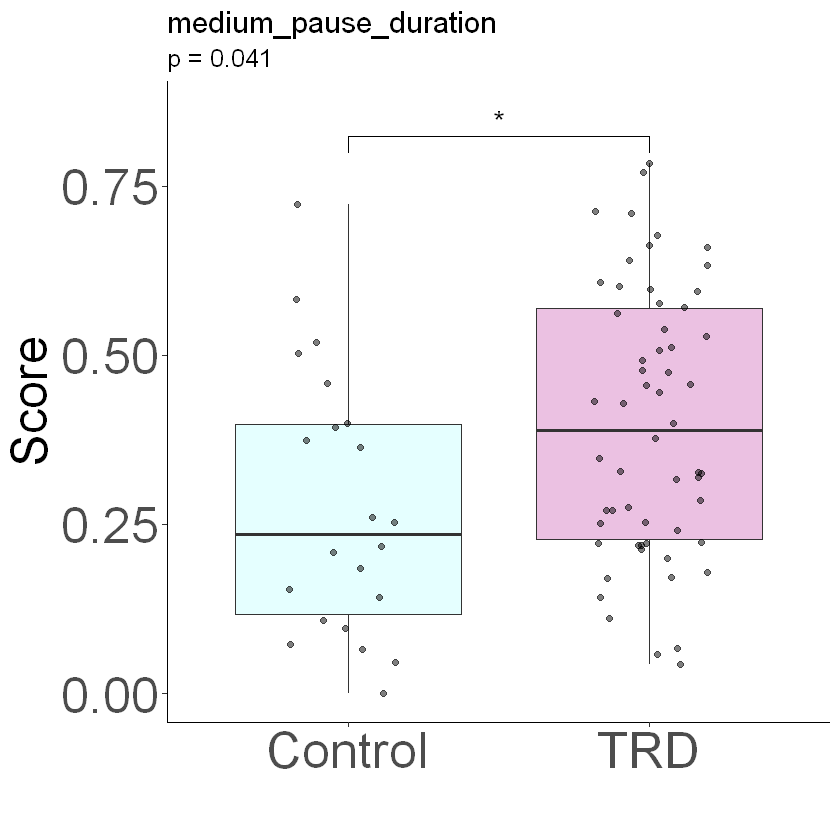

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


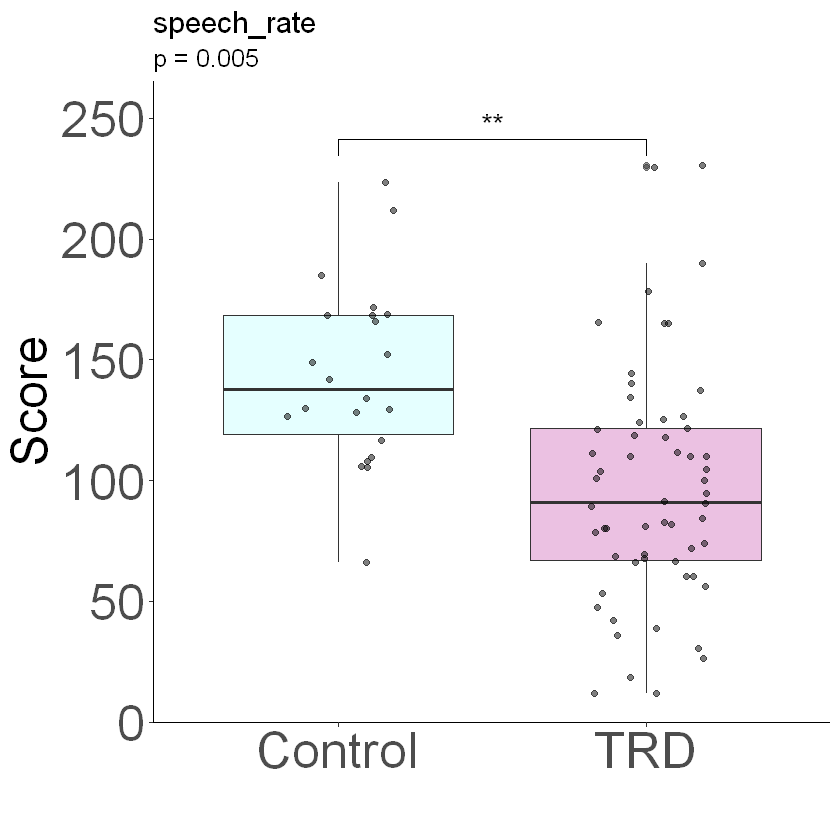

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


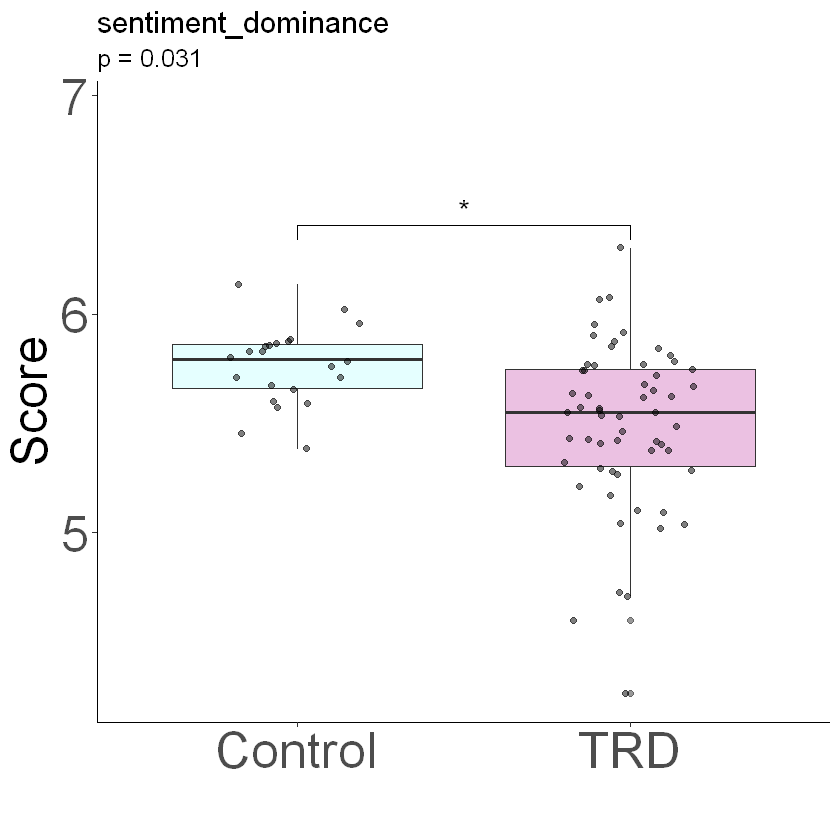

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


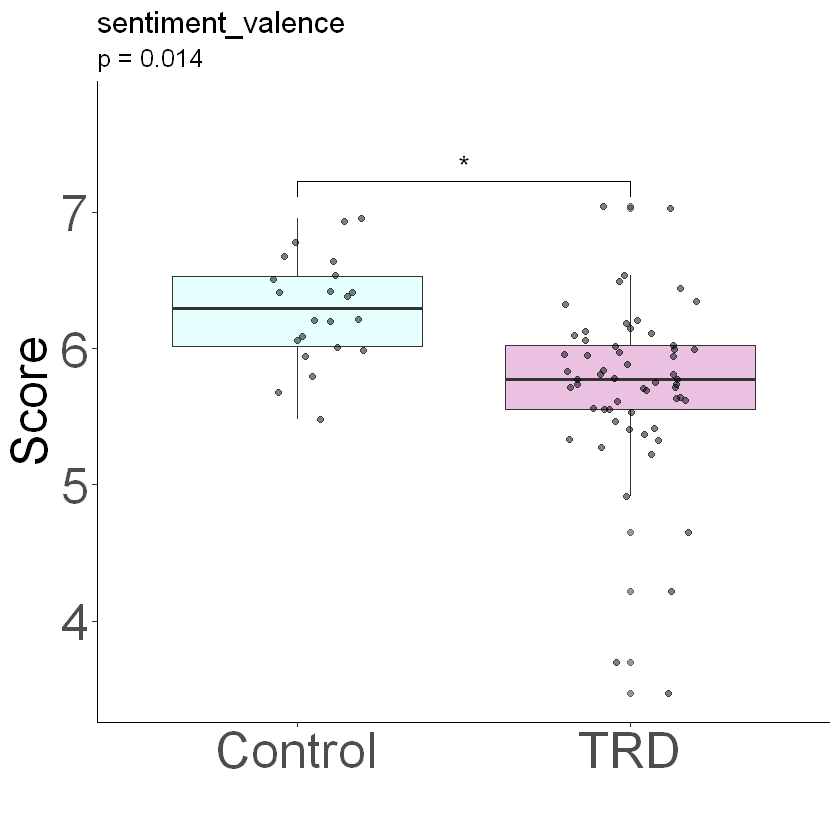

                        Variable    F_Value        Pr_F   Df
1     fundamental_frequency_mean 3.86195586 0.054027199 1/60
2 fundamental_frequency_variance 1.13480562 0.291020766 1/60
3              intensity_mean_db 0.01532387 0.901895632 1/60
4          medium_pause_duration 4.37942430 0.040612730 1/60
5                    speech_rate 8.37006373 0.005308814 1/60
6            sentiment_dominance 4.88575979 0.030903863 1/60
7              sentiment_valence 6.38576929 0.014157808 1/60
8              sentiment_arousal 5.88393146 0.018304318 1/60
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1        0.0604734980  139.3586281   38.8086944  171.6877246   36.7699026
2        0.0185623493 3835.2045400 3991.5414452 3248.1404111 2299.3665951
3        0.0002553325   54.3540631    5.3015429   55.8806789    7.4728731
4        0.0680252169    0.3991589    0.1964401    0.2782126    0.1962421
5        0.1224229330   96.6845948   48.4231440  143.9095138   37.2341350
6      

list()

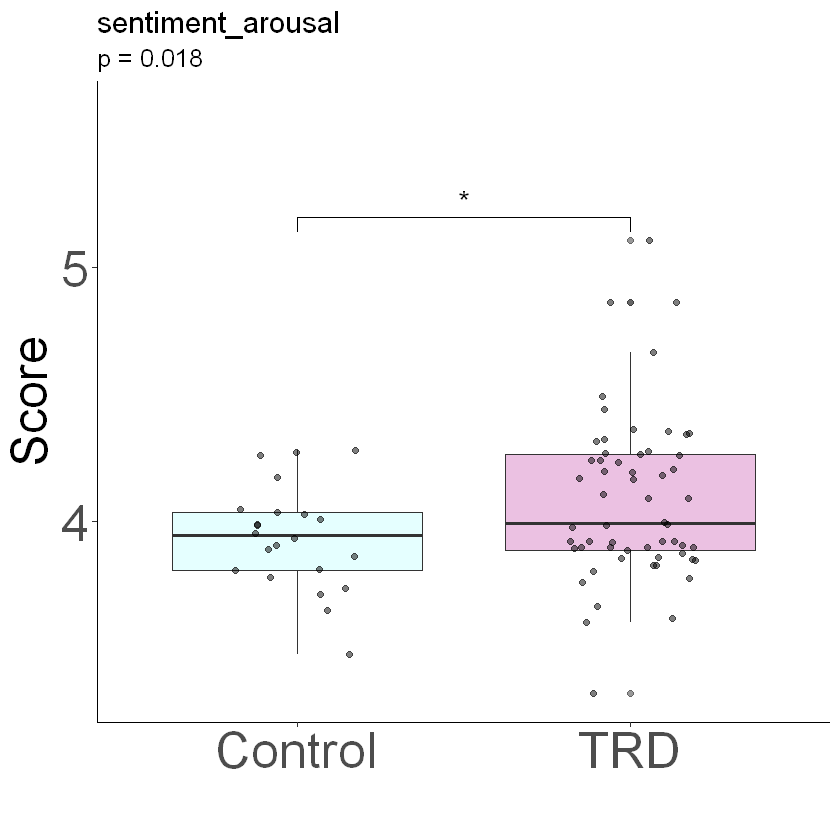

In [9]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", 'years_education')

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()


# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[7]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[7]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


controlling for education and testing location

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


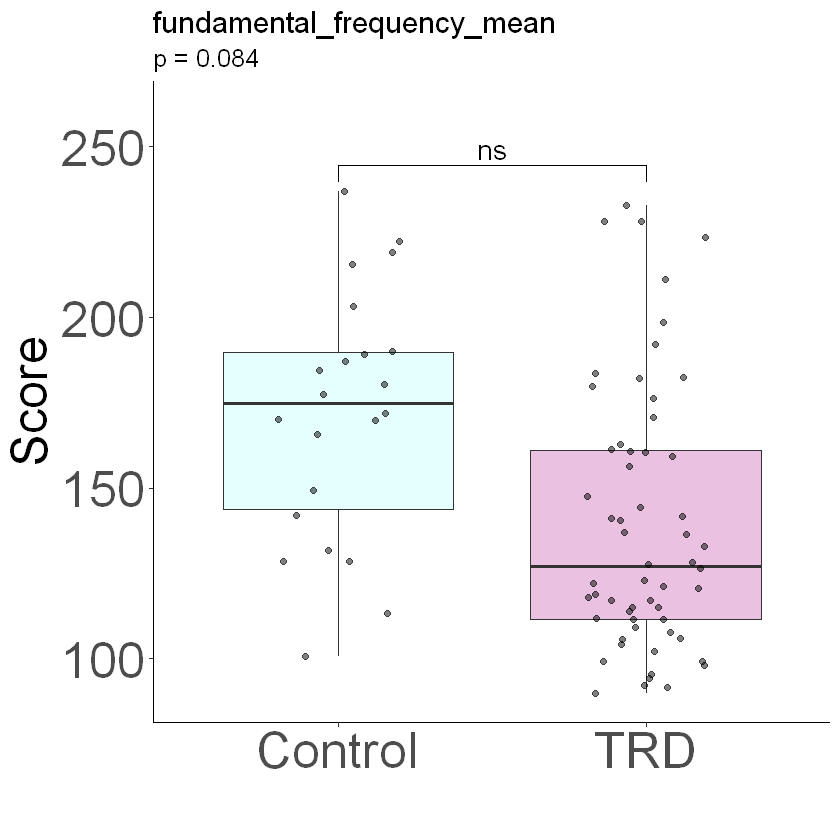

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


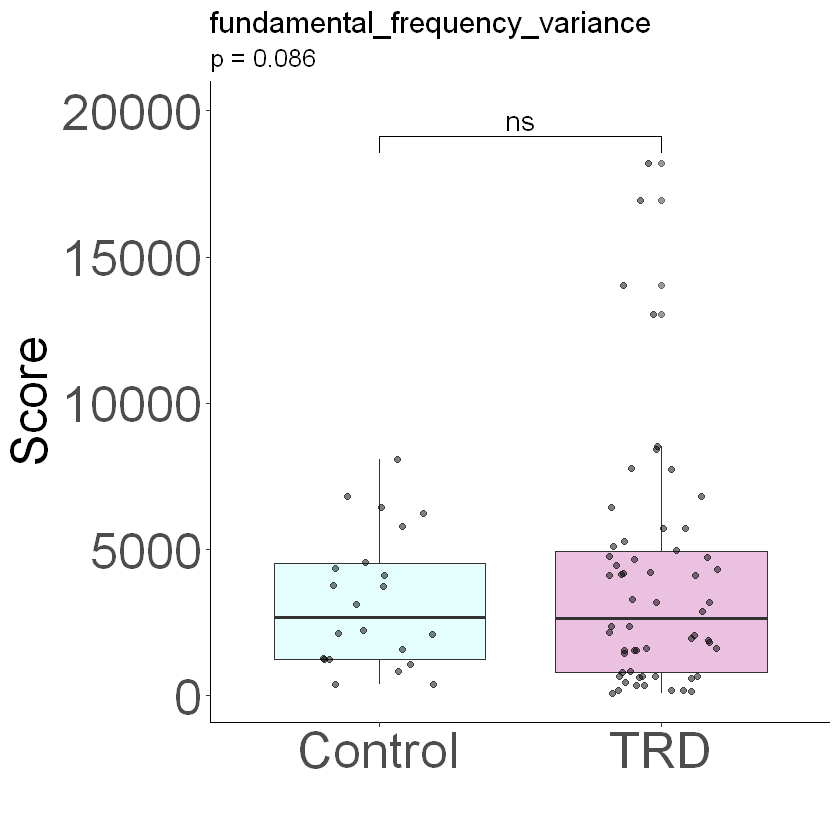

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


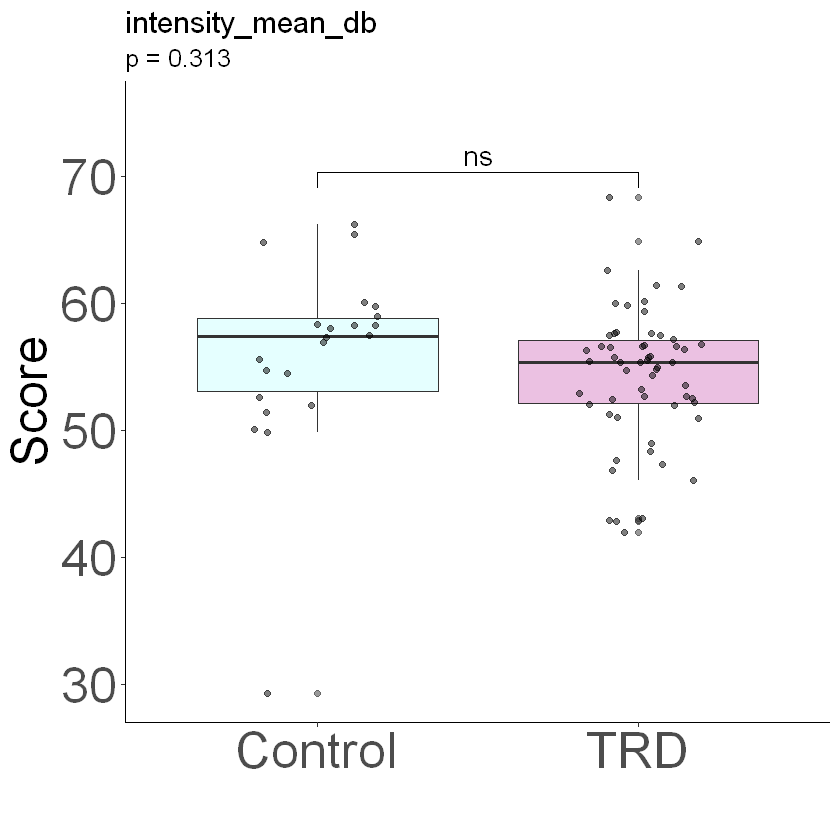

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


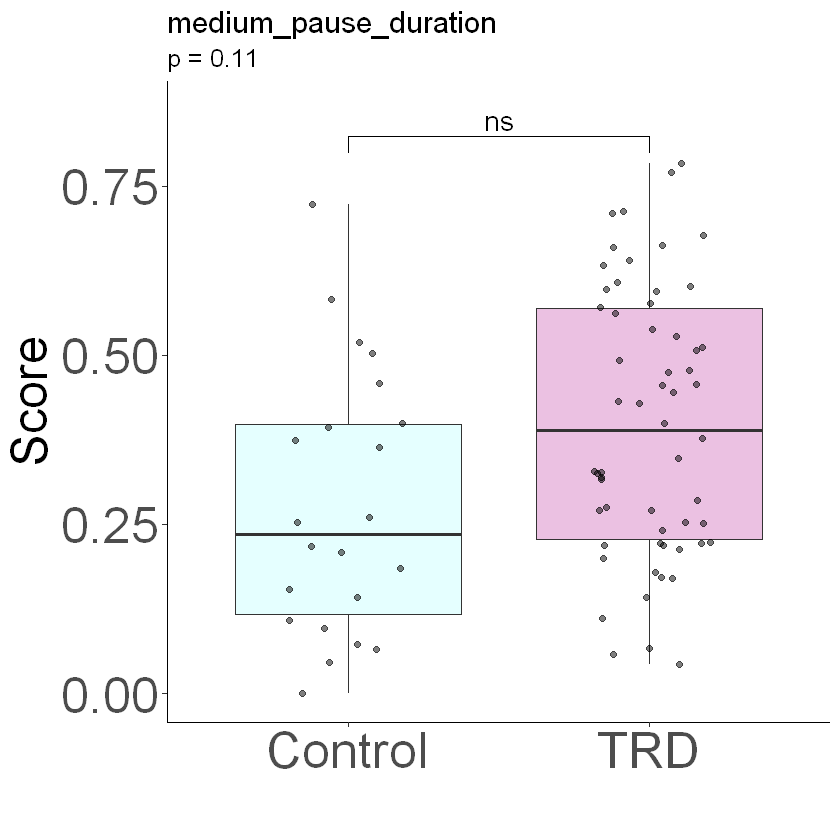

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


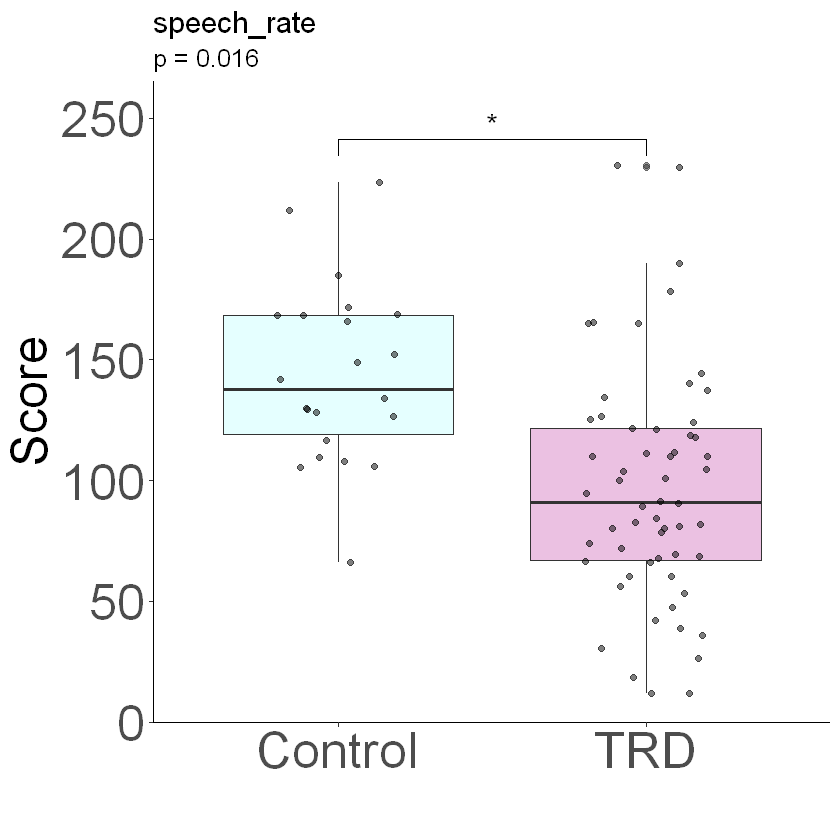

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


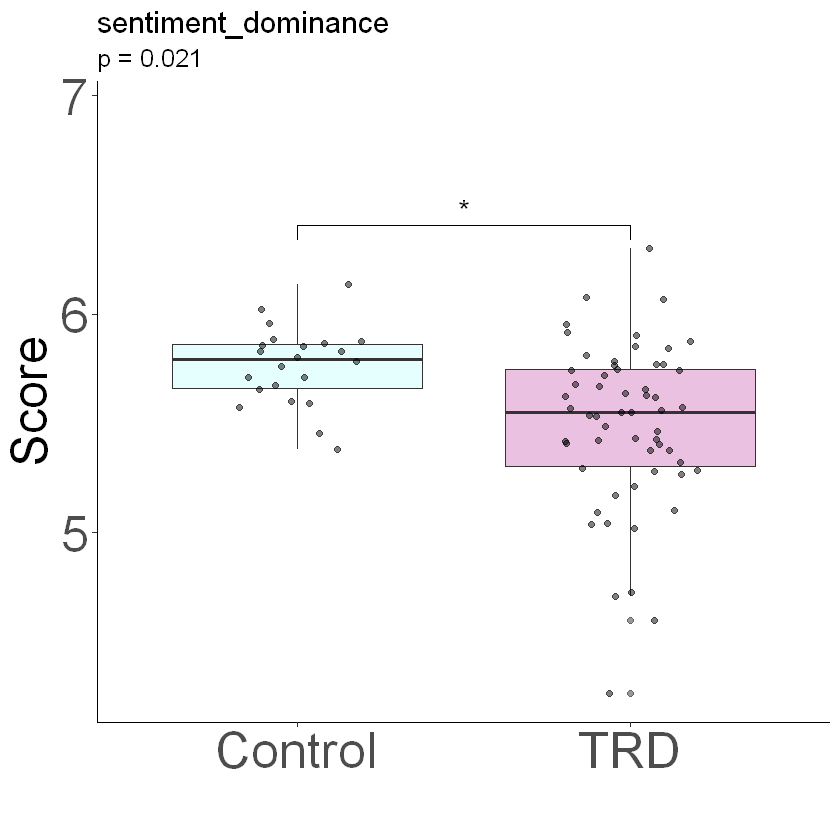

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


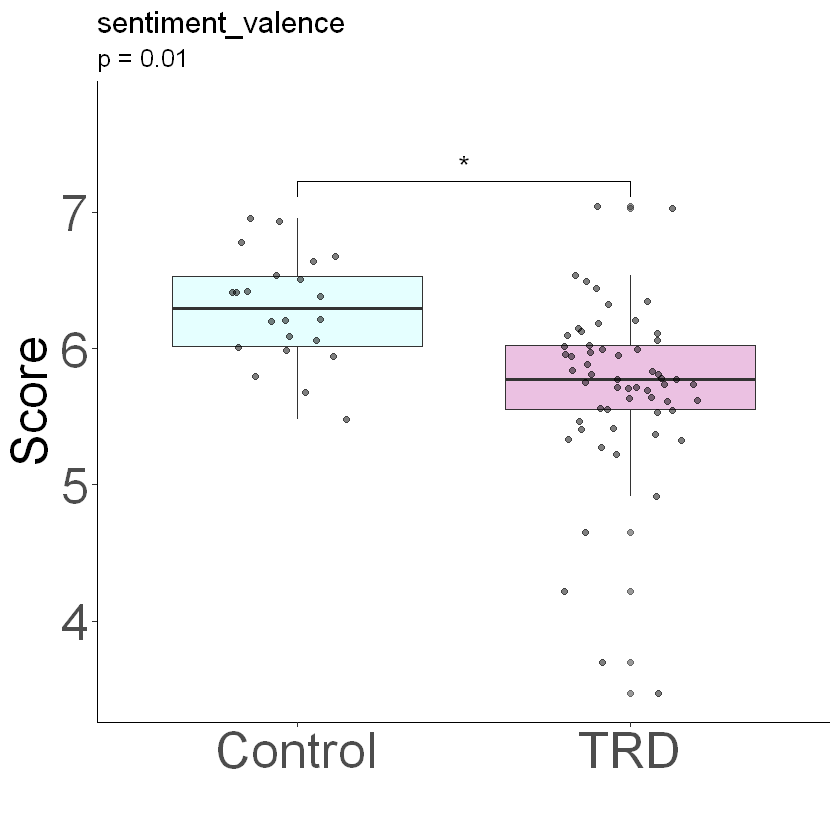

                        Variable  F_Value       Pr_F   Df Partial_Eta_Squared
1     fundamental_frequency_mean 3.097363 0.08360272 1/59          0.04987913
2 fundamental_frequency_variance 3.048814 0.08600123 1/59          0.04913573
3              intensity_mean_db 1.037532 0.31255504 1/59          0.01728138
4          medium_pause_duration 2.631107 0.11012092 1/59          0.04269121
5                    speech_rate 6.095445 0.01646835 1/59          0.09363858
6            sentiment_dominance 5.648468 0.02073391 1/59          0.08737203
7              sentiment_valence 7.017019 0.01034378 1/59          0.10629106
8              sentiment_arousal 3.440598 0.06861145 1/59          0.05510194
      Mean_MDD       SD_MDD Mean_Control   SD_Control
1  139.3586281   38.8086944  171.6877246   36.7699026
2 3835.2045400 3991.5414452 3248.1404111 2299.3665951
3   54.3540631    5.3015429   55.8806789    7.4728731
4    0.3991589    0.1964401    0.2782126    0.1962421
5   96.6845948   48.4231440 

list()

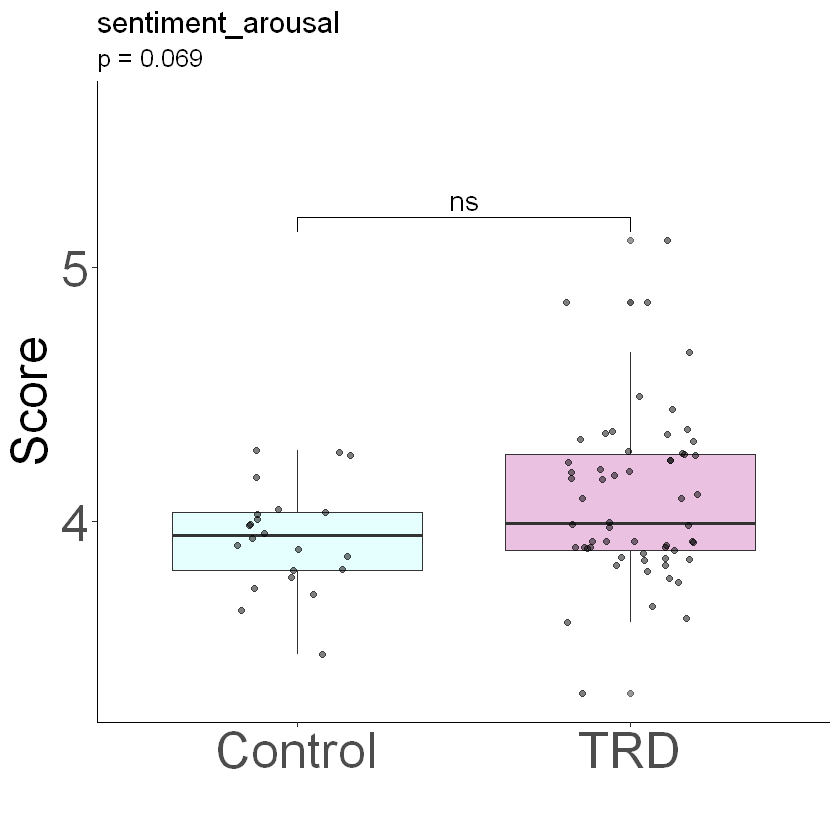

In [10]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", 'years_education','testing_location')

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()


# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[8]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[8]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


Controlling for testing location

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


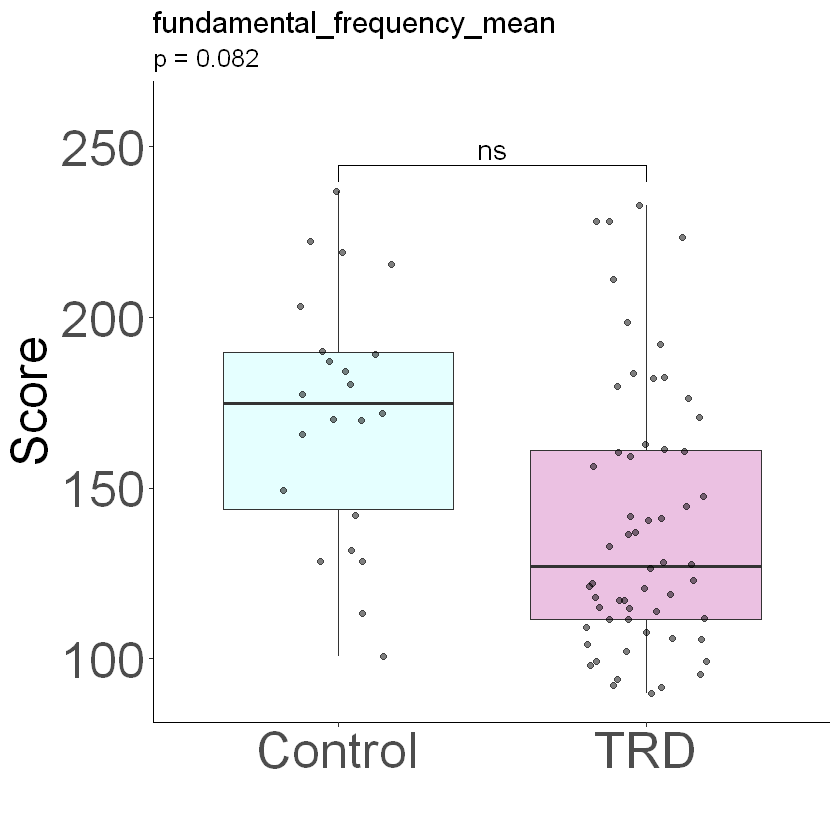

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


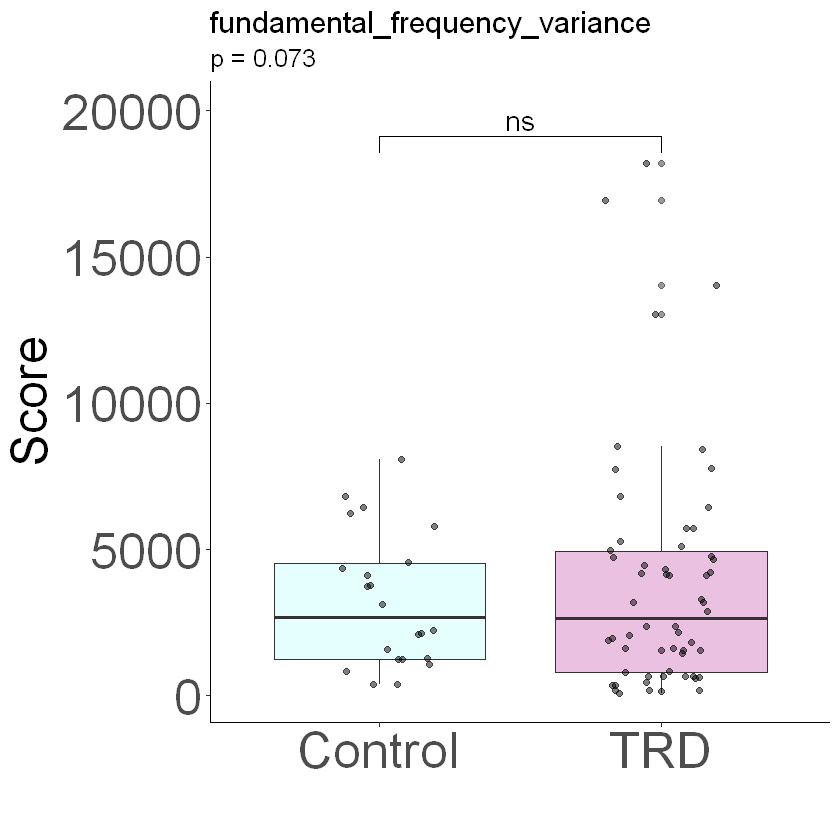

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


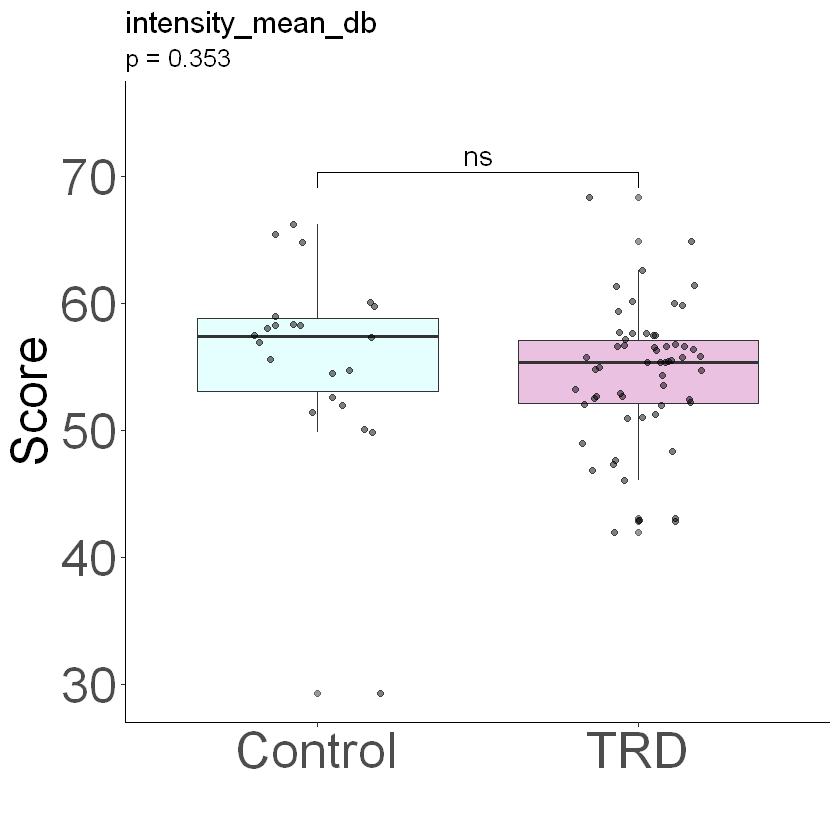

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


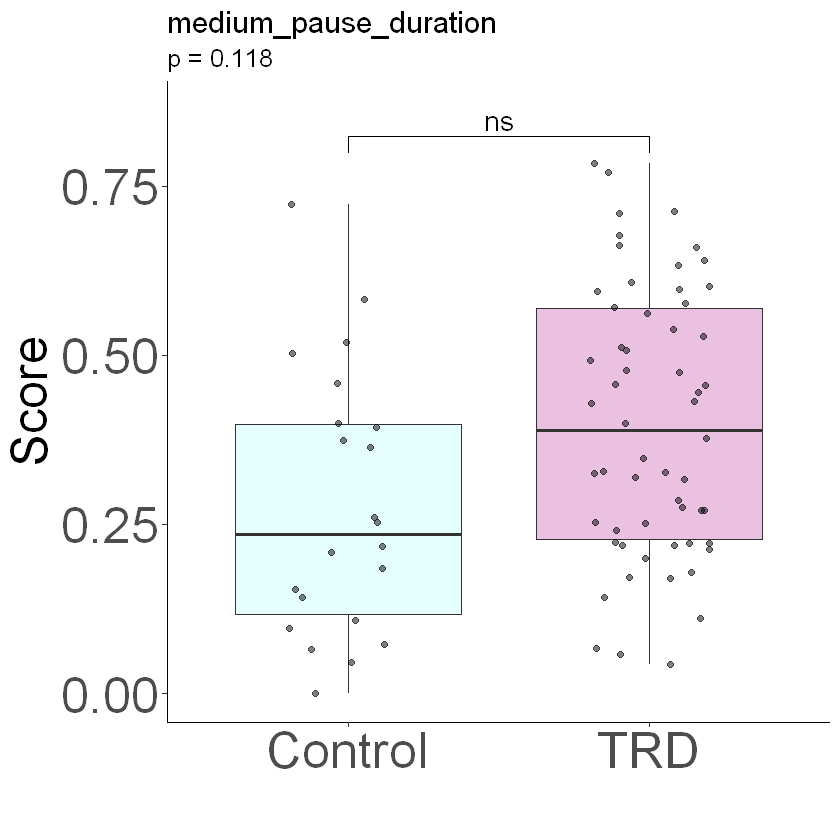

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


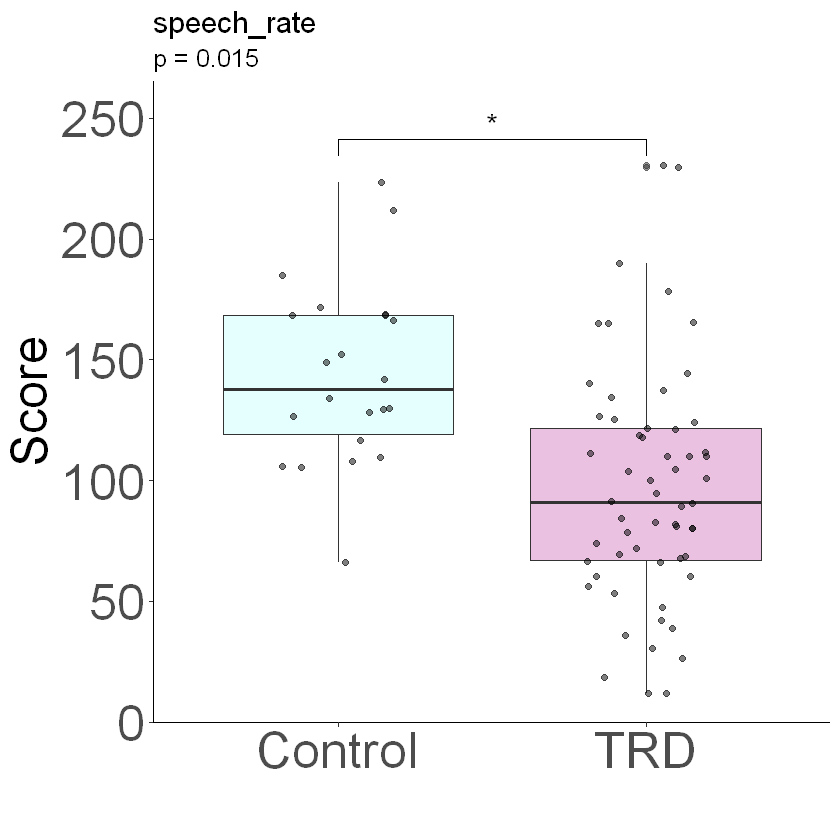

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


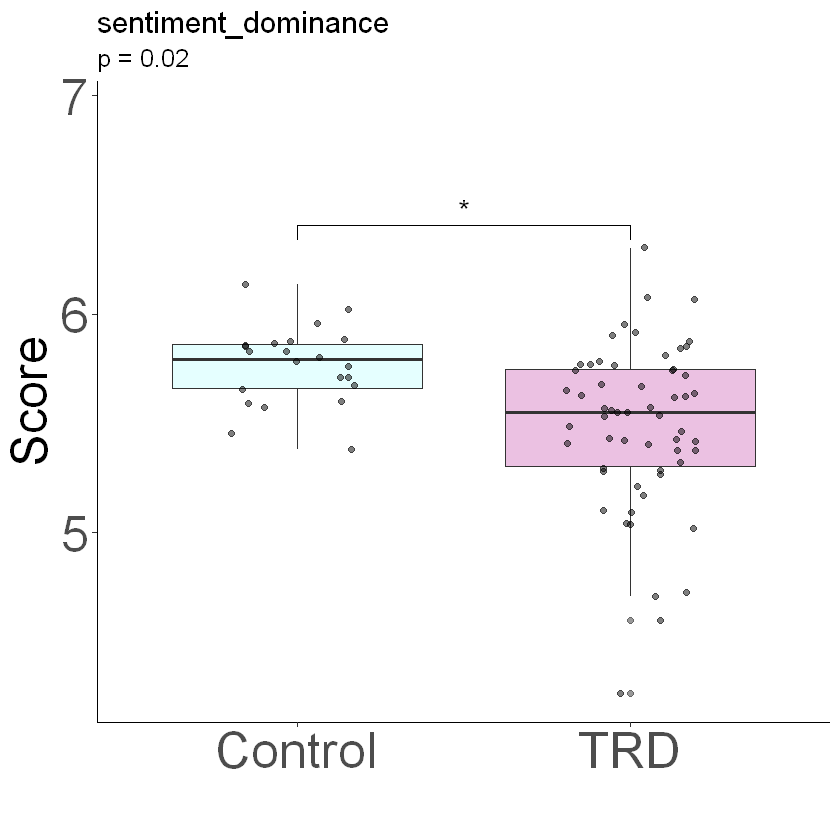

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`)."
Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


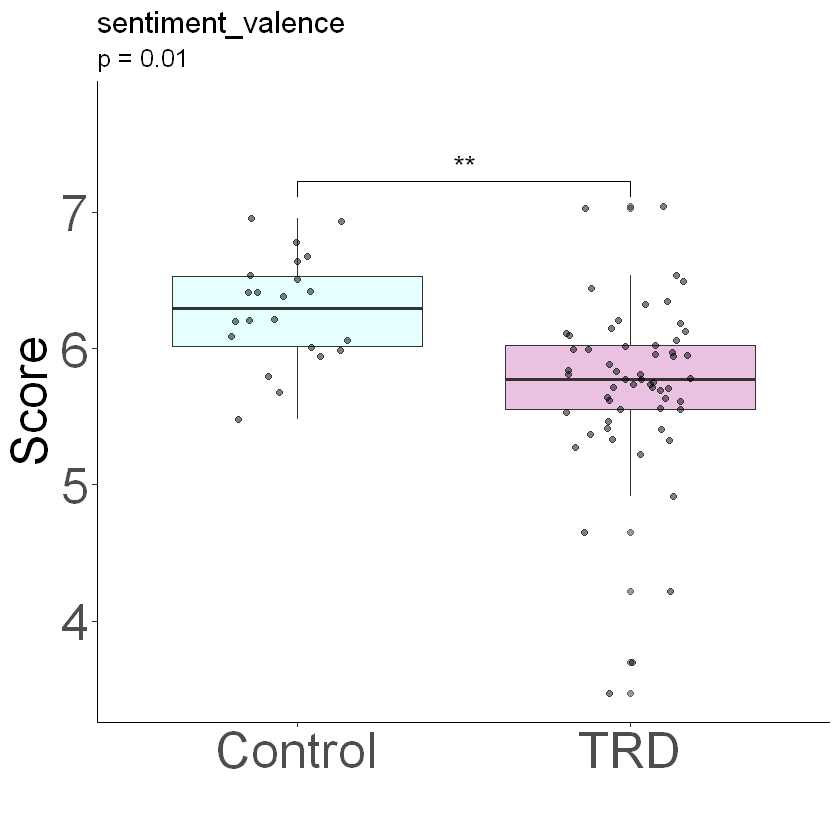

                        Variable   F_Value        Pr_F   Df Partial_Eta_Squared
1     fundamental_frequency_mean 3.1280850 0.081953703 1/61          0.04877871
2 fundamental_frequency_variance 3.3391805 0.072540795 1/61          0.05189964
3              intensity_mean_db 0.8754557 0.353138838 1/61          0.01414867
4          medium_pause_duration 2.5183644 0.117697847 1/61          0.03964782
5                    speech_rate 6.2737572 0.014941683 1/61          0.09325713
6            sentiment_dominance 5.6619936 0.020479413 1/61          0.08493586
7              sentiment_valence 7.1441951 0.009634575 1/61          0.10483938
8              sentiment_arousal 3.5695297 0.063604420 1/61          0.05528195
      Mean_MDD       SD_MDD Mean_Control   SD_Control
1  139.3586281   38.8086944  171.6877246   36.7699026
2 3835.2045400 3991.5414452 3248.1404111 2299.3665951
3   54.3540631    5.3015429   55.8806789    7.4728731
4    0.3991589    0.1964401    0.2782126    0.1962421
5   96.684

list()

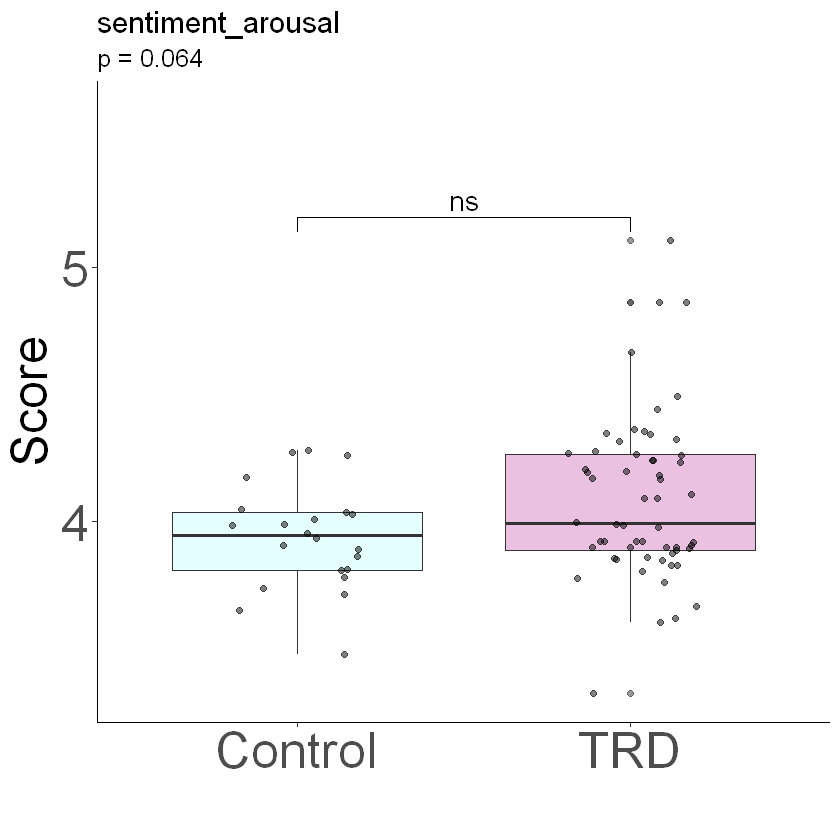

In [11]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", 'testing_location')

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()


# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[7]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[7]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


Controlling for total duration audio 

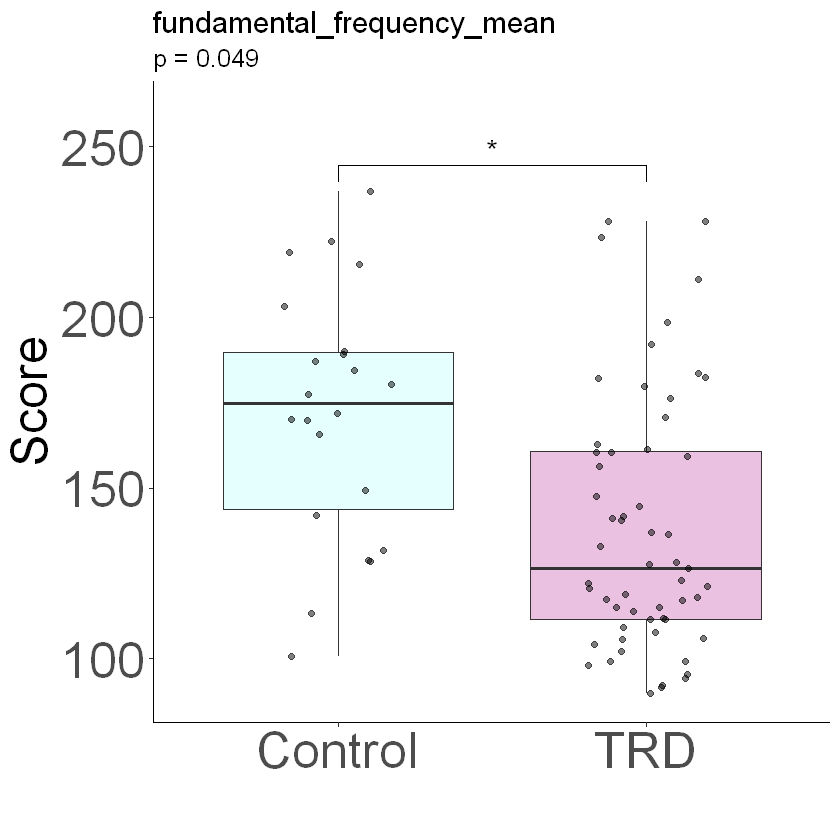

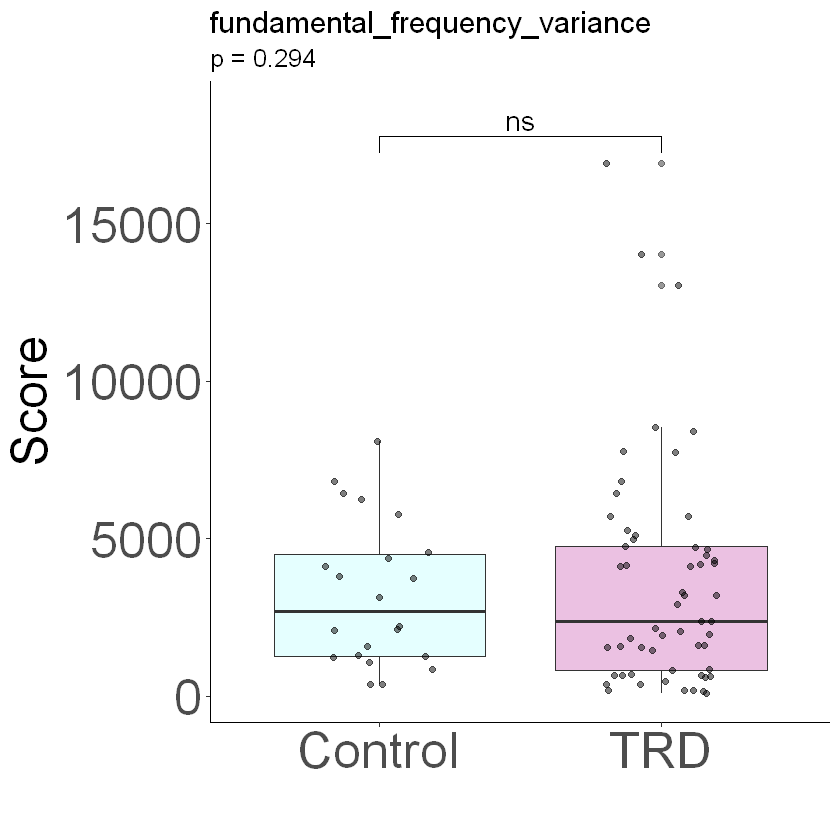

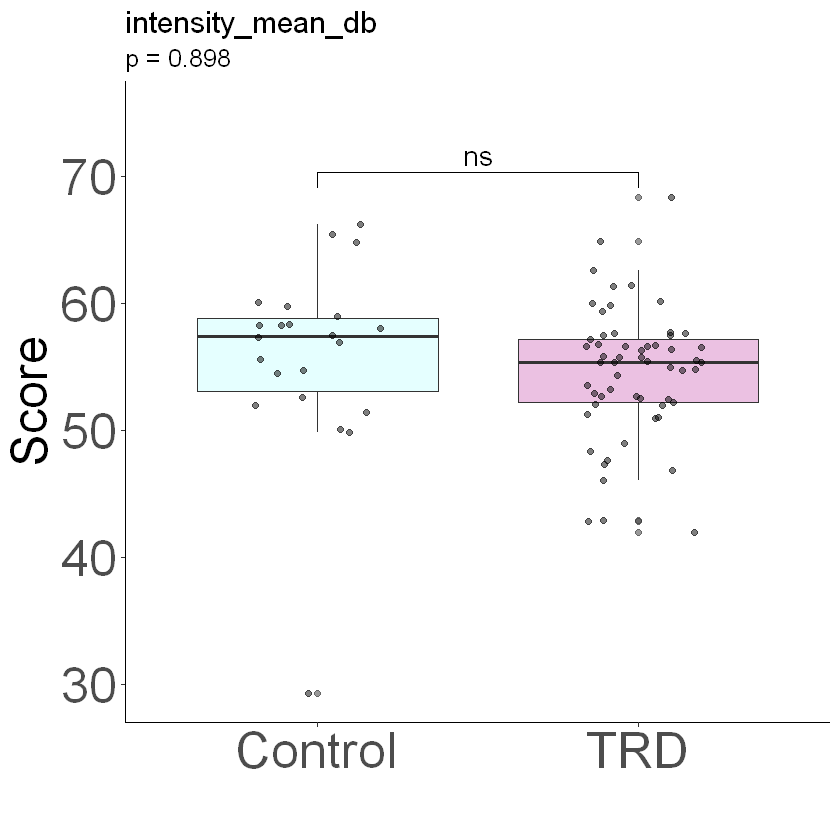

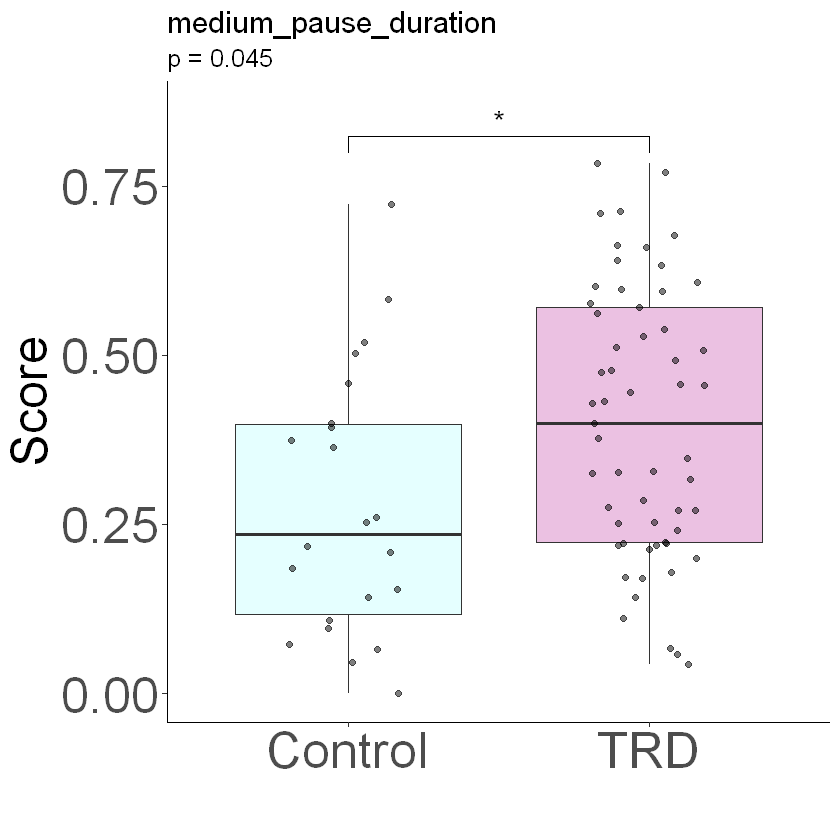

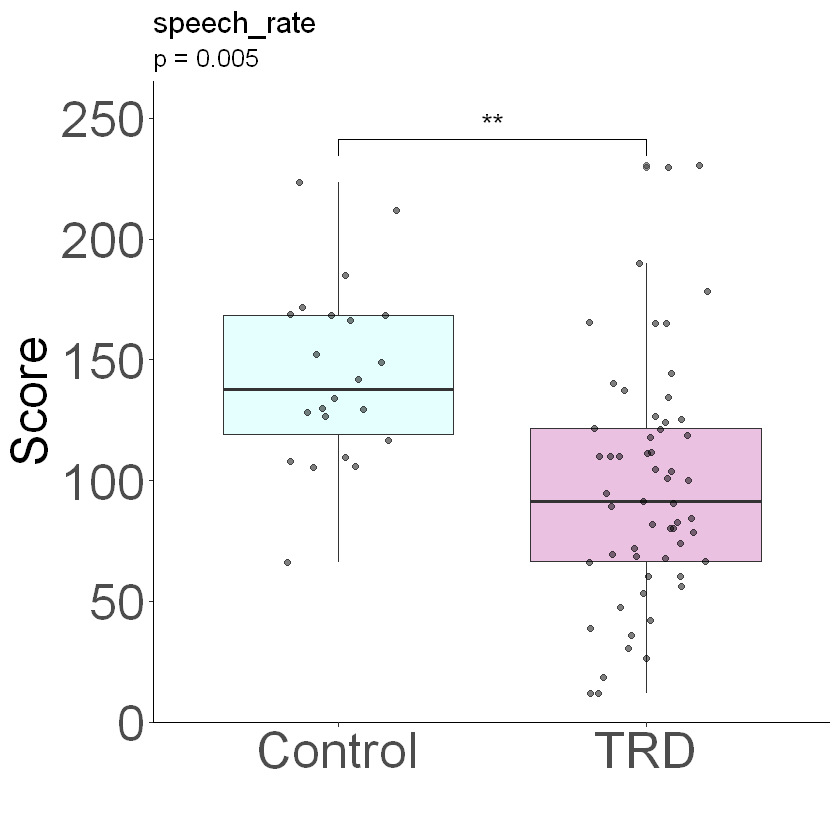

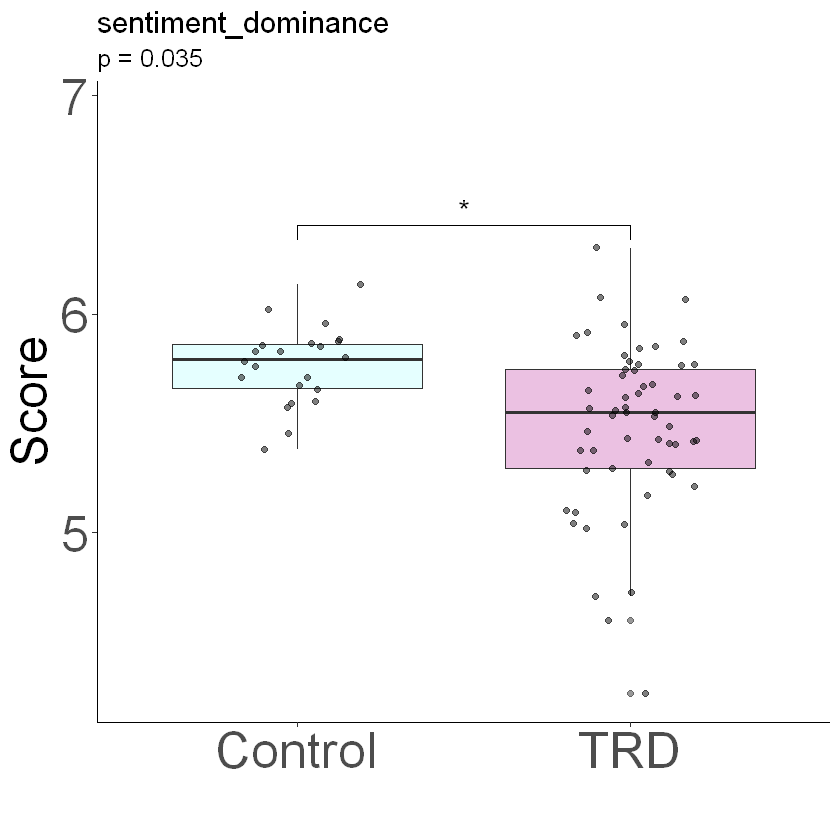

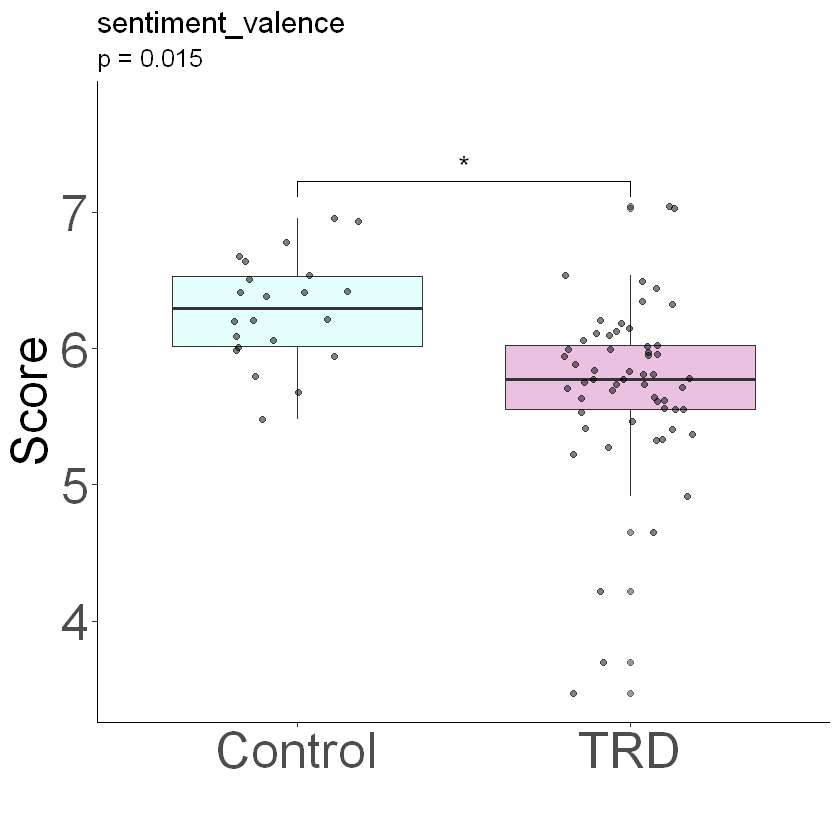

                        Variable    F_Value        Pr_F   Df
1     fundamental_frequency_mean 4.02770714 0.049196168 1/61
2 fundamental_frequency_variance 1.12005282 0.294080094 1/61
3              intensity_mean_db 0.01665956 0.897725372 1/61
4          medium_pause_duration 4.17795591 0.045277042 1/61
5                    speech_rate 8.48257778 0.005003407 1/61
6            sentiment_dominance 4.63609255 0.035268818 1/61
7              sentiment_valence 6.30966857 0.014670414 1/61
8              sentiment_arousal 5.70237652 0.020053814 1/61
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1         0.061938323  137.7174595   37.0675174  171.6877246   36.7699026
2         0.018030455 3583.2062040 3530.9992663 3248.1404111 2299.3665951
3         0.000273033   54.5524199    5.1269358   55.8806789    7.4728731
4         0.064100751    0.4005456    0.1978997    0.2782126    0.1962421
5         0.122082082   96.9619358   48.8070836  143.9095138   37.2341350
6      

list()

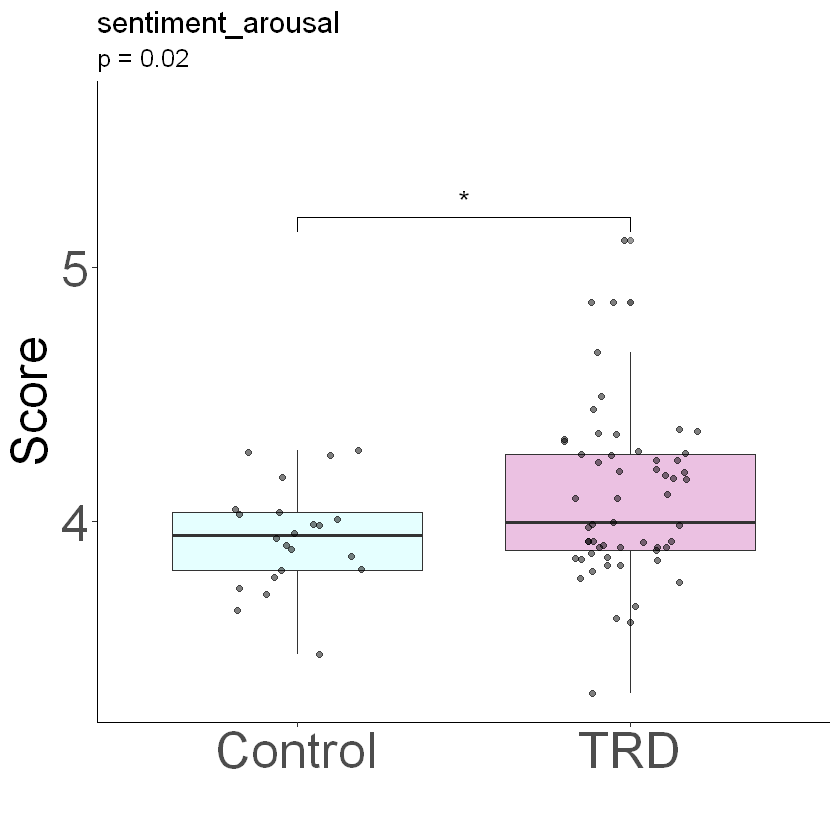

In [47]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", "total_duration_audio")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[7]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[7]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


Controlling for total words 

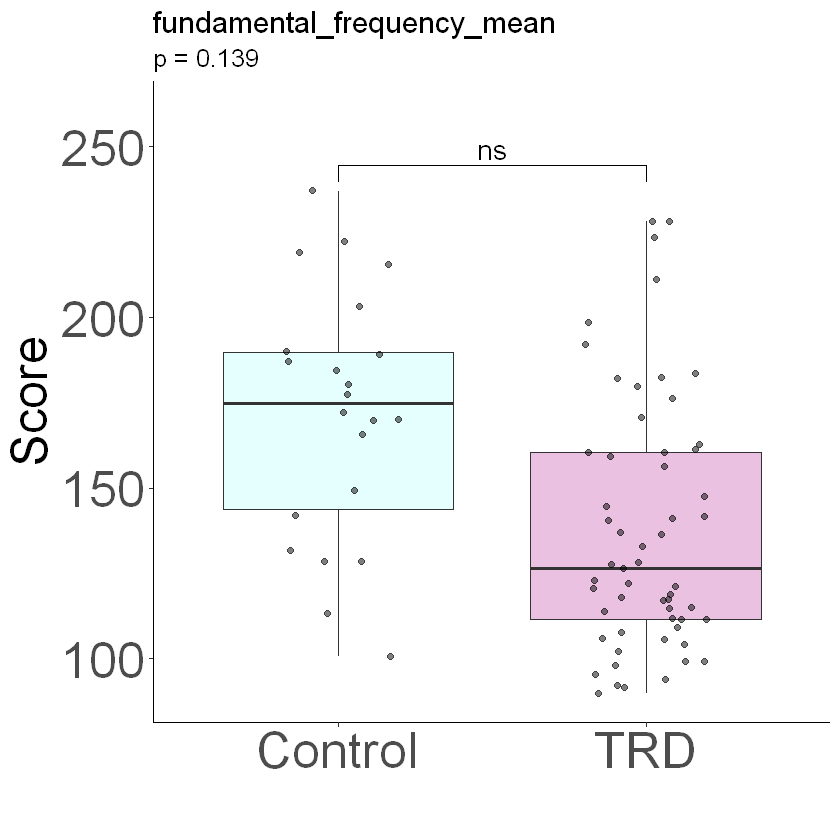

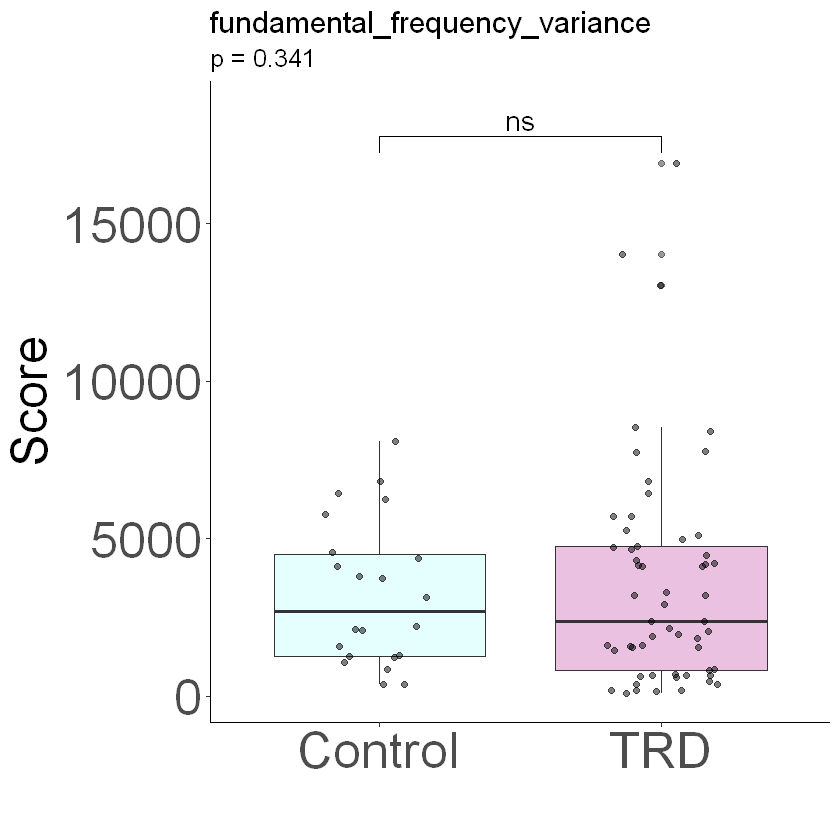

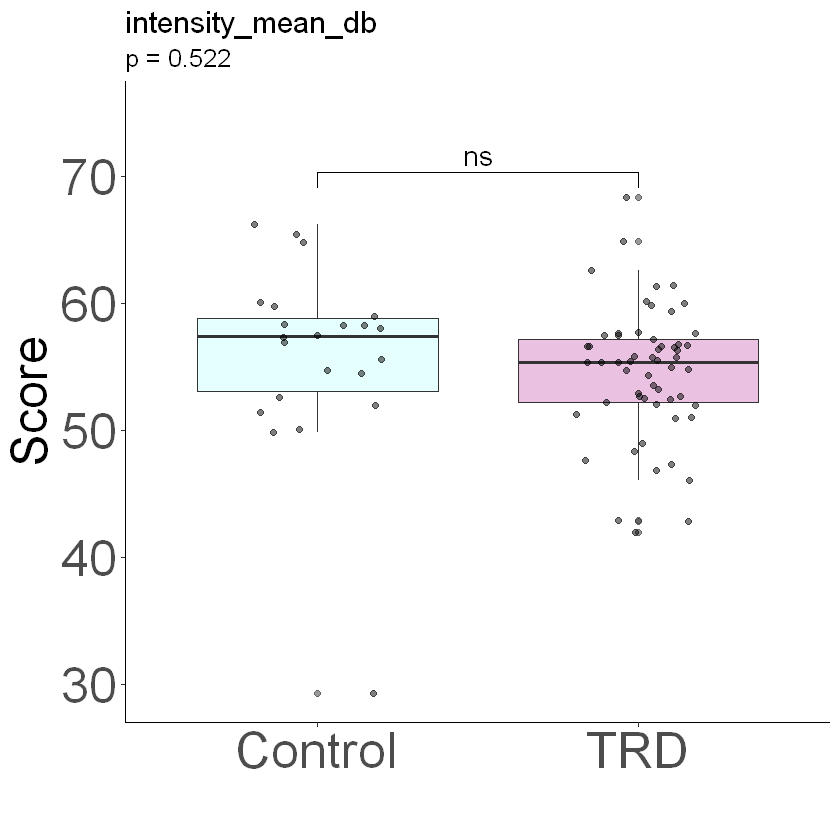

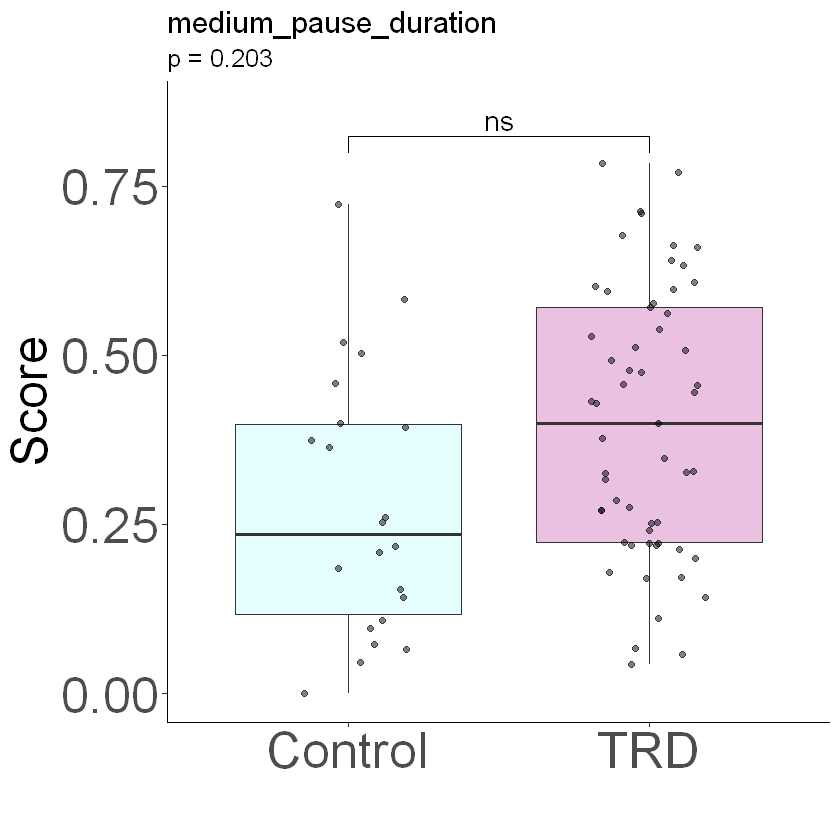

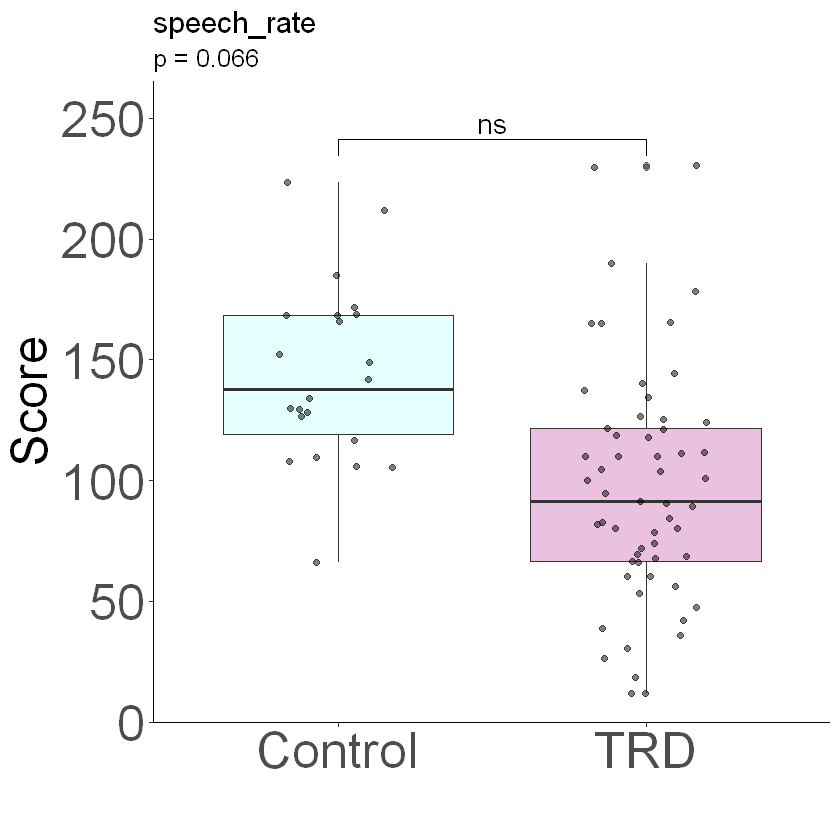

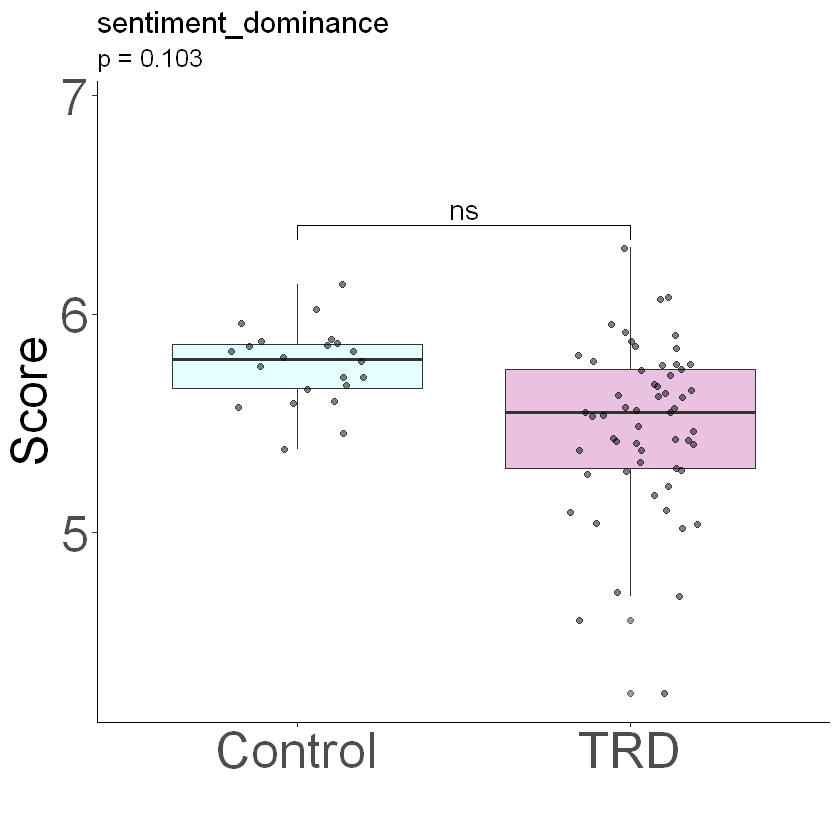

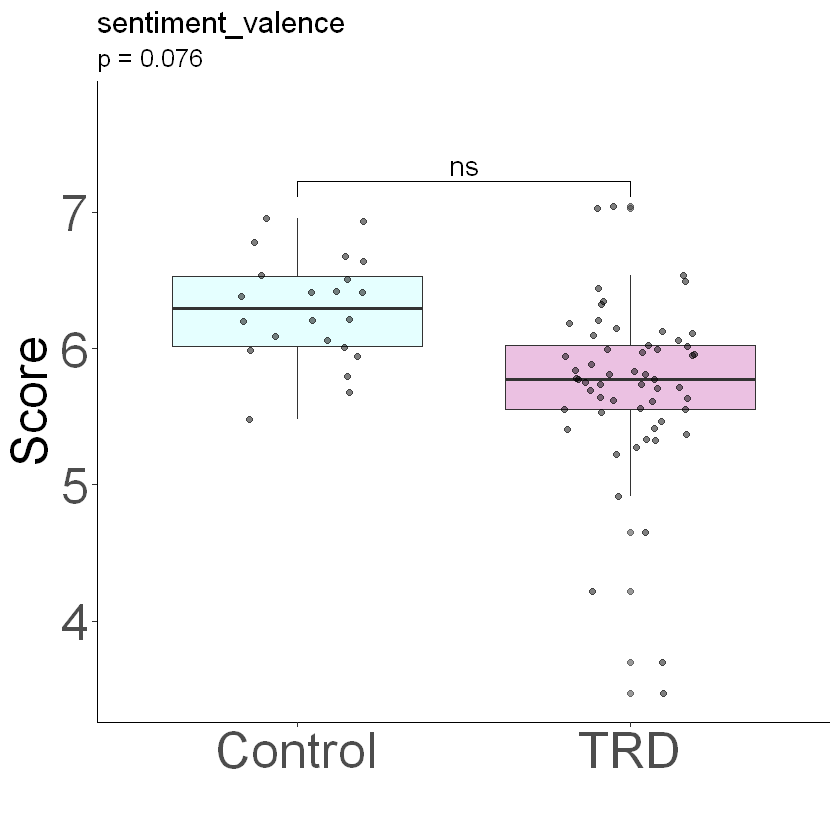

                        Variable   F_Value       Pr_F   Df Partial_Eta_Squared
1     fundamental_frequency_mean 2.2428921 0.13938677 1/61         0.035464730
2 fundamental_frequency_variance 0.9197805 0.34131859 1/61         0.014854389
3              intensity_mean_db 0.4156429 0.52153643 1/61         0.006767705
4          medium_pause_duration 1.6582046 0.20270990 1/61         0.026464285
5                    speech_rate 3.4944708 0.06637623 1/61         0.054182486
6            sentiment_dominance 2.7415549 0.10290571 1/61         0.043010480
7              sentiment_valence 3.2625976 0.07581039 1/61         0.050769774
8              sentiment_arousal 3.2838556 0.07488684 1/61         0.051083675
      Mean_MDD       SD_MDD Mean_Control   SD_Control
1  137.7174595   37.0675174  171.6877246   36.7699026
2 3583.2062040 3530.9992663 3248.1404111 2299.3665951
3   54.5524199    5.1269358   55.8806789    7.4728731
4    0.4005456    0.1978997    0.2782126    0.1962421
5   96.9619358   48

list()

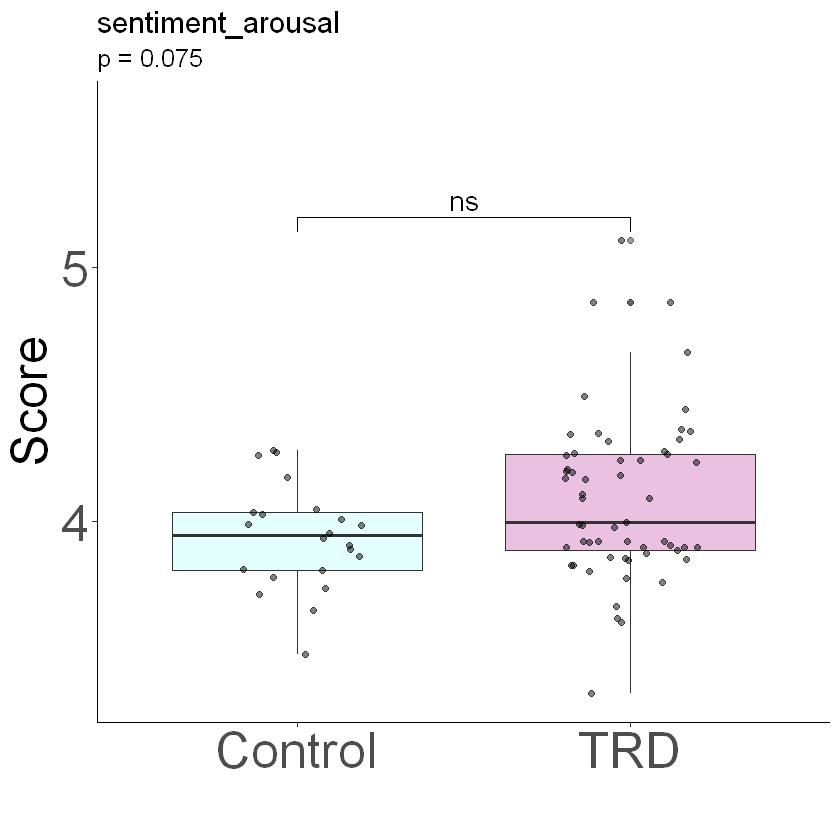

In [46]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", "total_words")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[7]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[7]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


Remove outliers for total words 

[1] "Outliers removed:"
# A tibble: 7 × 2
  participant_external_id total_words
  <chr>                         <dbl>
1 TMS005                        0.583
2 TMS019                        0.5  
3 TMS020                        0.364
4 TMS030                        0.444
5 TMS042                        0.583
6 TMS056                        0.548
7 CTC070                        1.2  


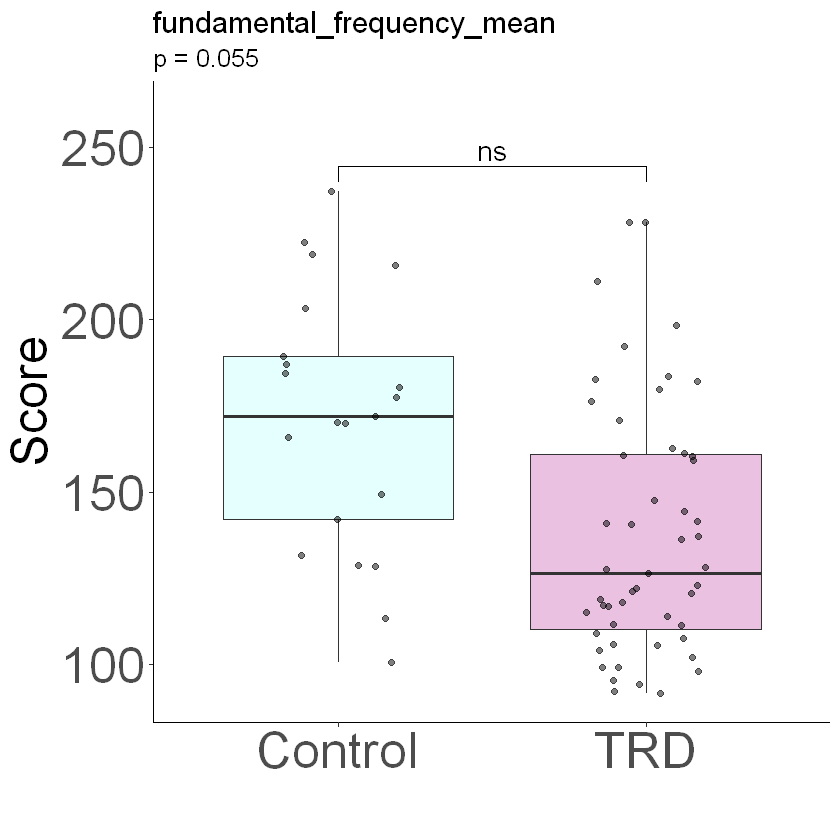

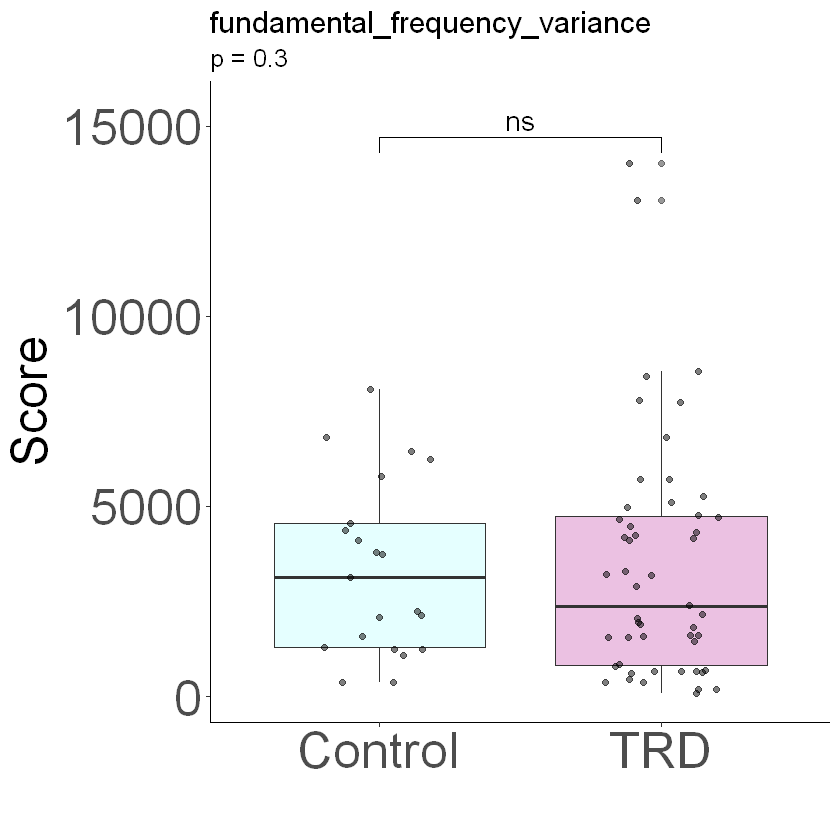

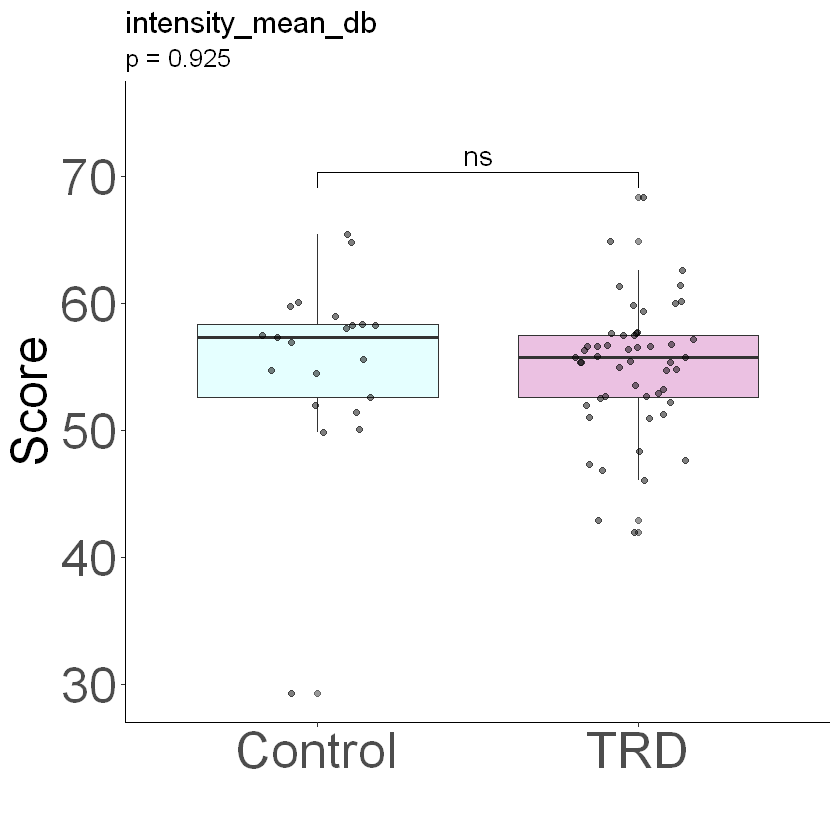

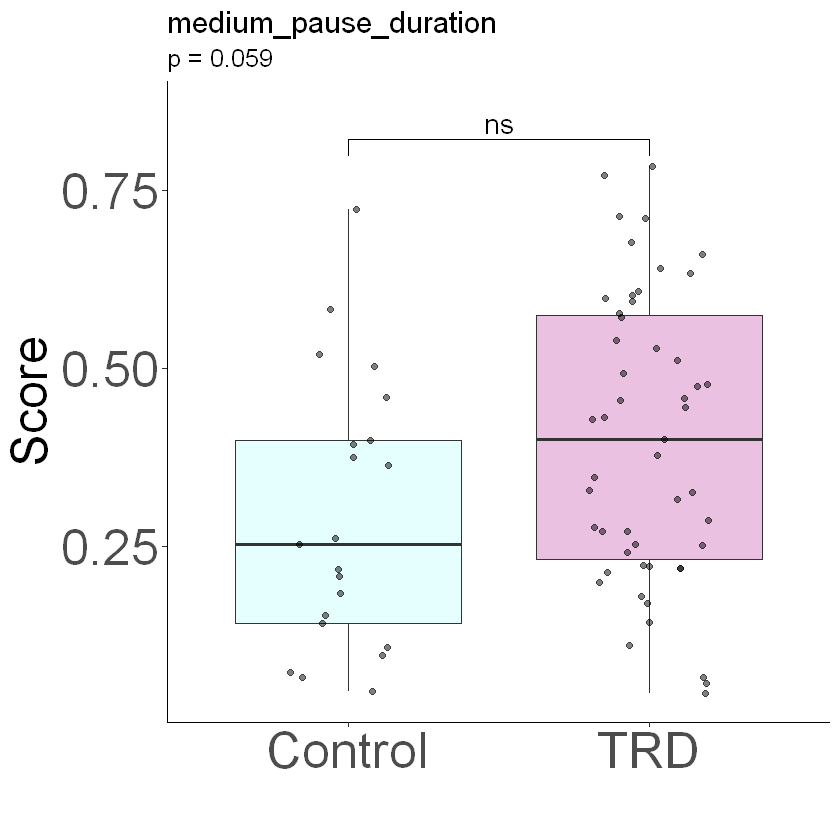

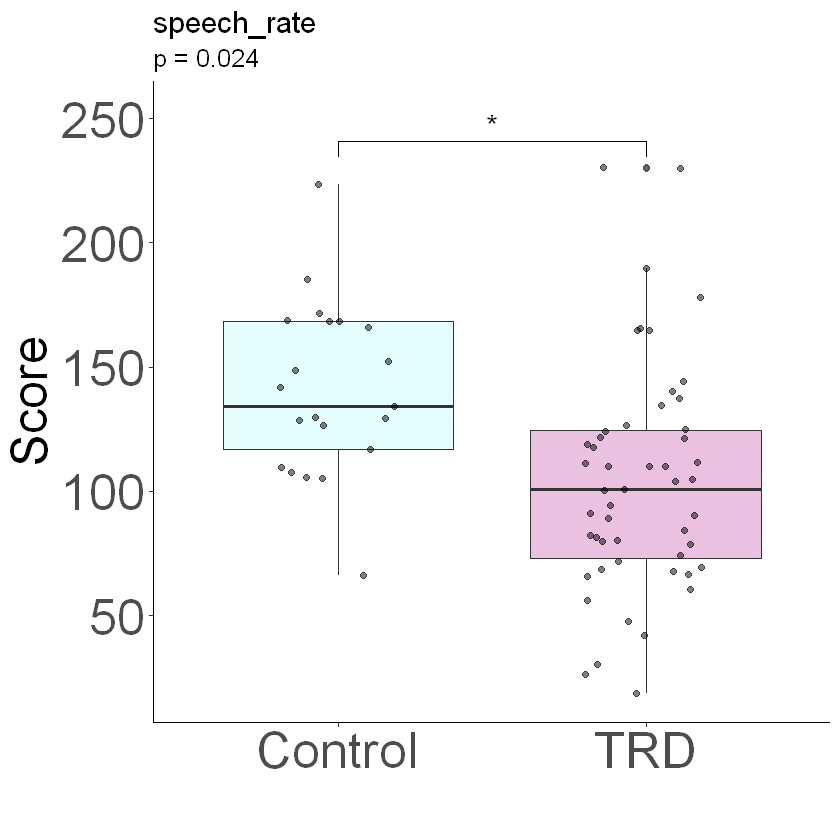

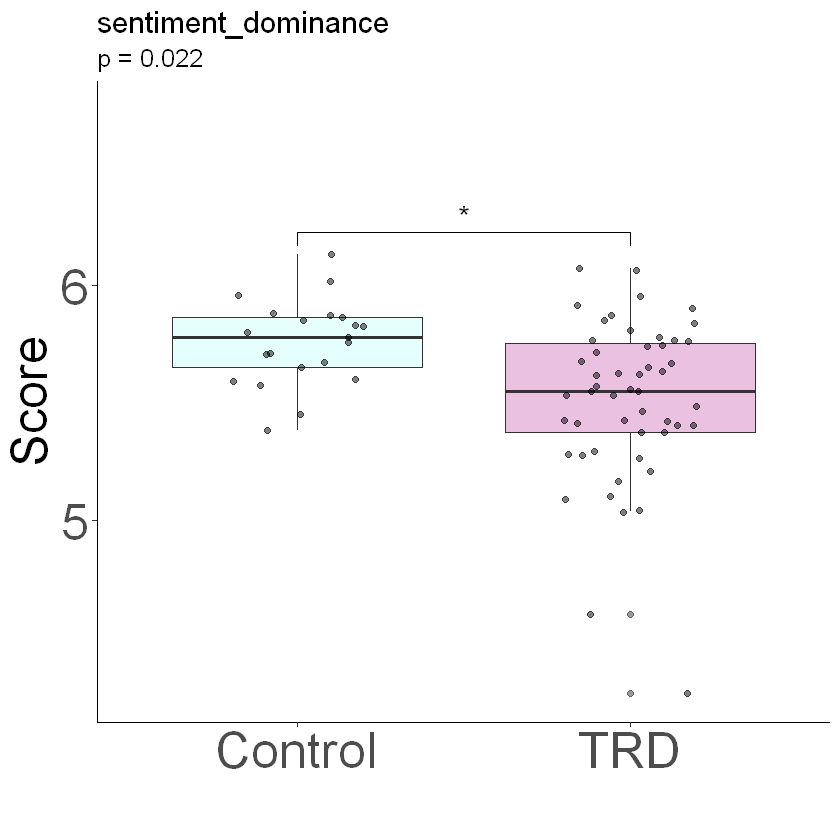

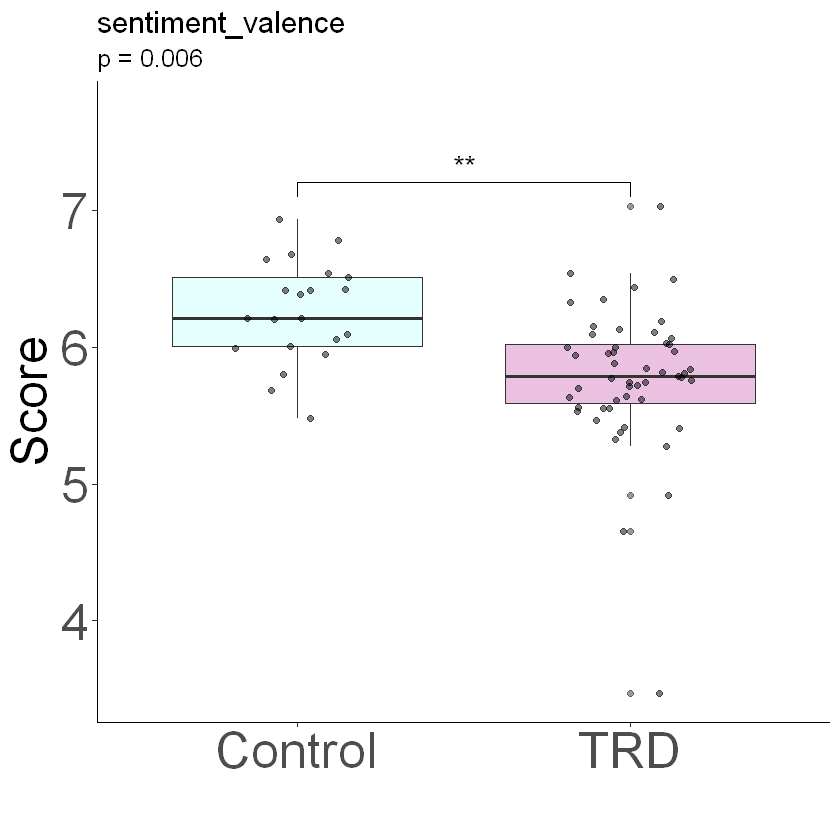

                        Variable     F_Value        Pr_F   Df
1     fundamental_frequency_mean 3.828672986 0.055375882 1/56
2 fundamental_frequency_variance 1.095021581 0.299857065 1/56
3              intensity_mean_db 0.008848688 0.925391332 1/56
4          medium_pause_duration 3.727448377 0.058594109 1/56
5                    speech_rate 5.402777923 0.023756824 1/56
6            sentiment_dominance 5.531374561 0.022220549 1/56
7              sentiment_valence 8.215408063 0.005841473 1/56
8              sentiment_arousal 5.203270389 0.026369208 1/56
  Partial_Eta_Squared     Mean_MDD       SD_MDD Mean_Control   SD_Control
1        0.0639939480  137.6667683   36.2638452  170.8122762   37.4422616
2        0.0191789328 3413.6289901 3116.6114570 3362.2645178 2291.4142958
3        0.0001579873   54.9702225    5.0643732   55.3905790    7.2861135
4        0.0624076280    0.3995538    0.1998539    0.2914633    0.1907369
5        0.0879891449  104.2207228   46.0026123  140.6783142   34.849975

list()

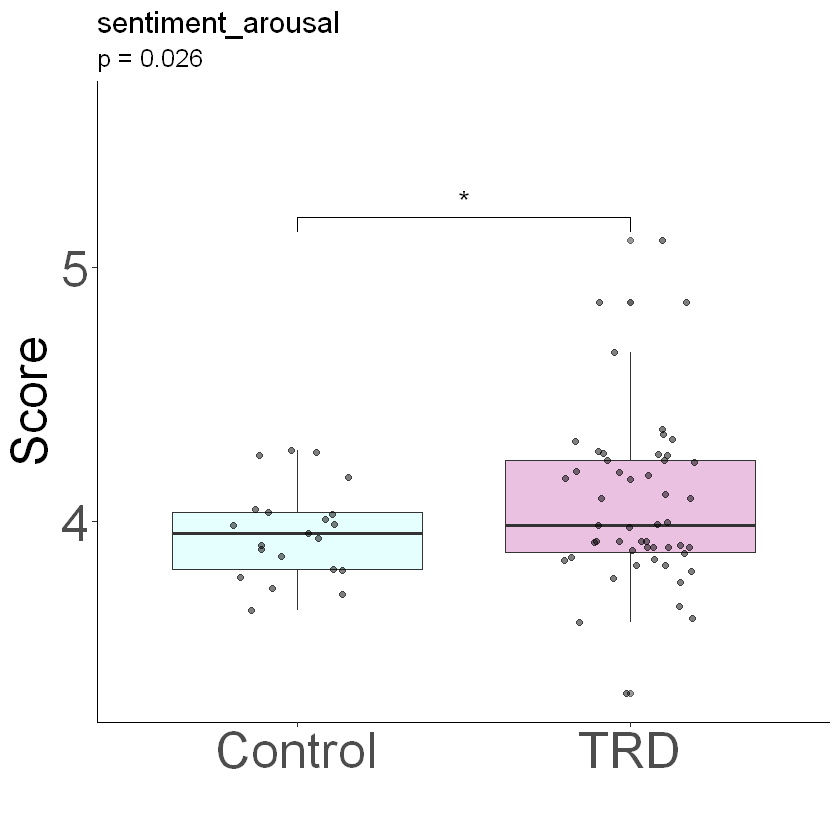

In [60]:
cleaned_df_tot_wds_outliers <- WL_jou_bl_feeling %>% 
  filter(total_words >= outlier_threshold_low_tot_wds & total_words <= outlier_threshold_high_tot_wds)

# Filter to find rows that will be removed (those below the outlier threshold)
rows_to_remove <- WL_jou_bl_feeling %>% 
  filter(total_words < outlier_threshold_low_tot_wds | total_words > outlier_threshold_high_tot_wds) %>%
  select(participant_external_id, total_words)

# Print the participant_ID and total_words for rows to be removed
print("Outliers removed:")
print(rows_to_remove)

library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)



p_values_ancovas <- c()

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- cleaned_df_tot_wds_outliers[!is.na(cleaned_df_tot_wds_outliers$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[6]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[6]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)


Ancovas controlling for testing location 

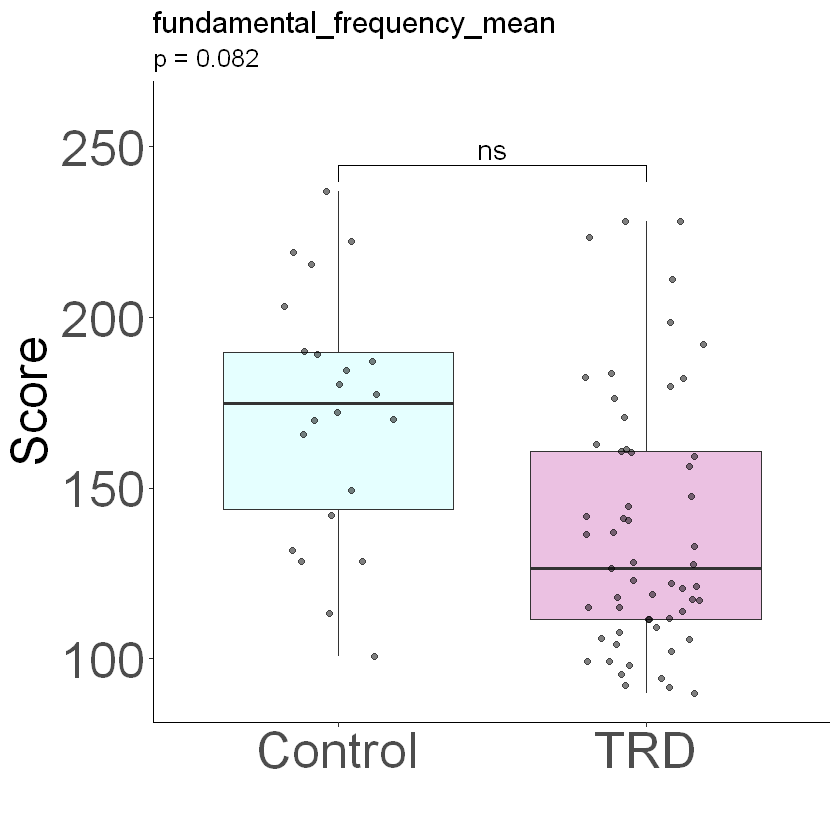

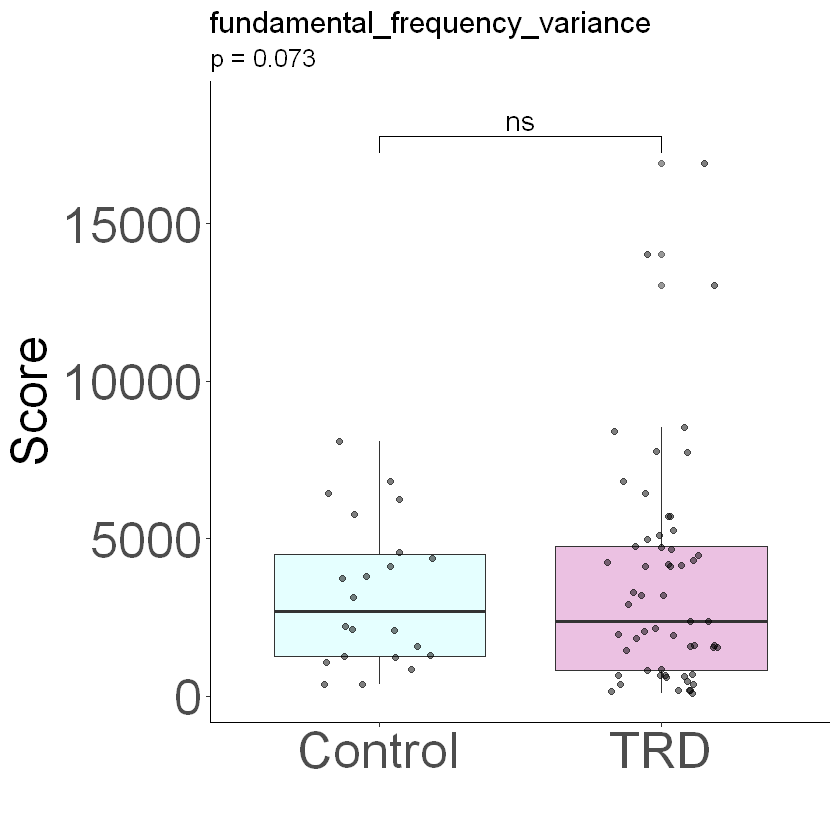

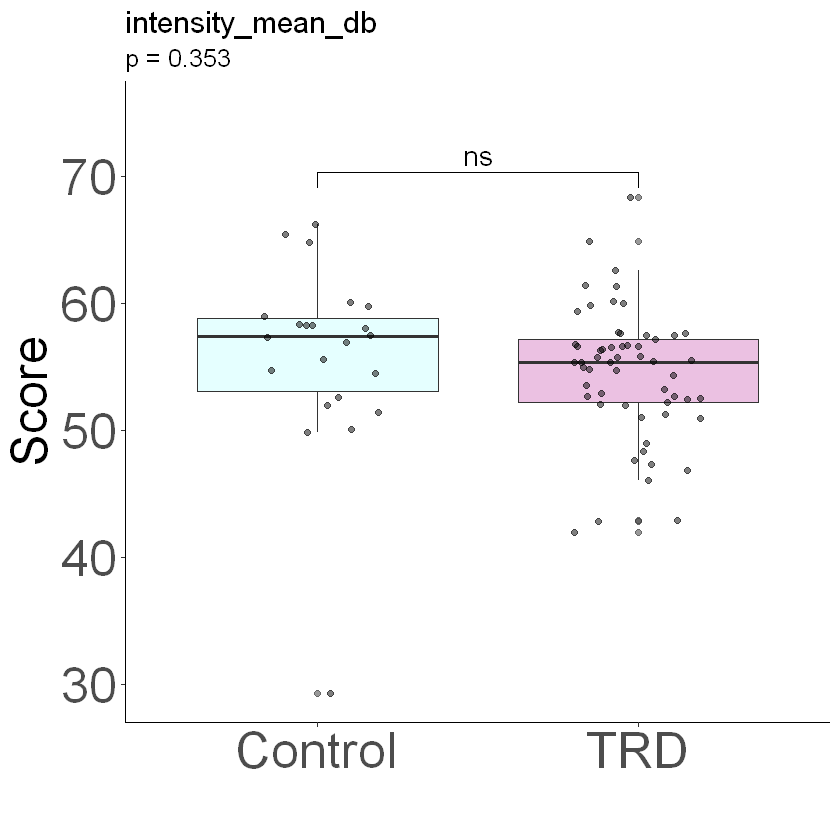

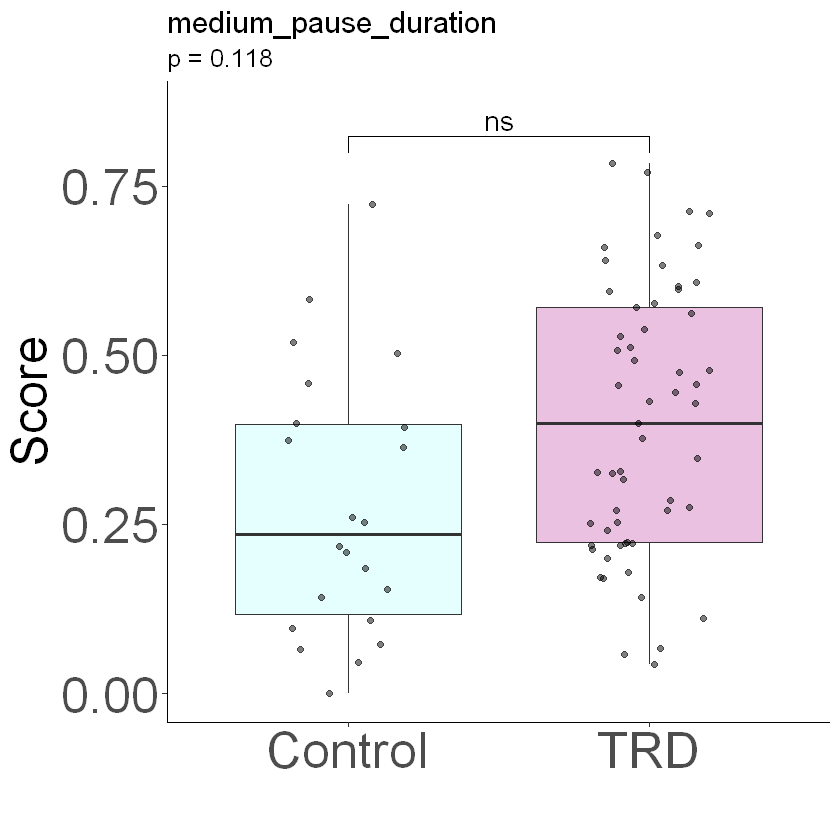

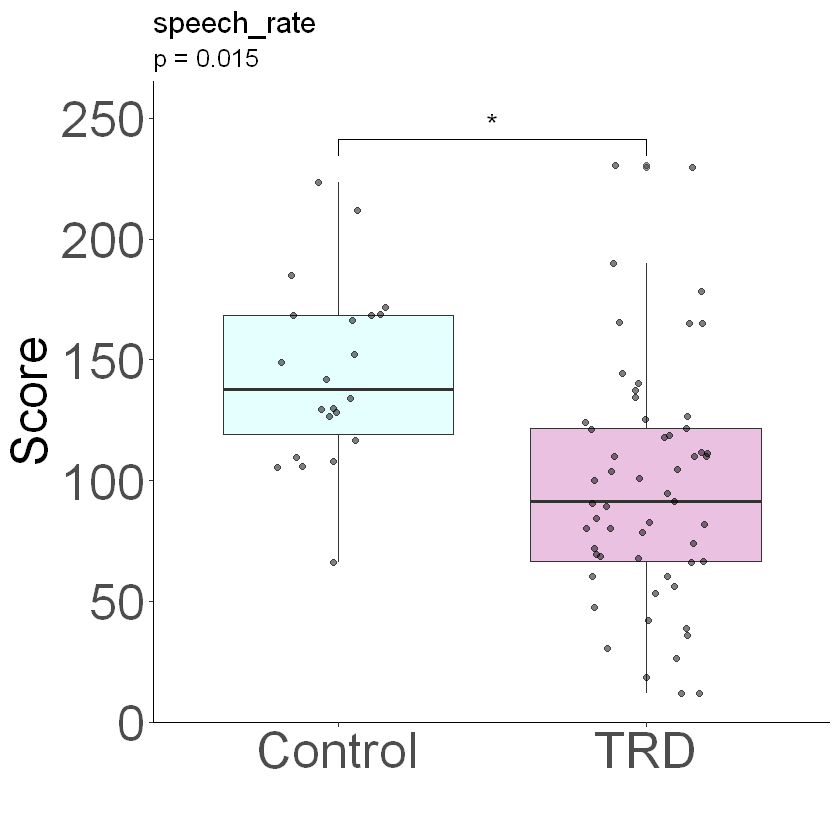

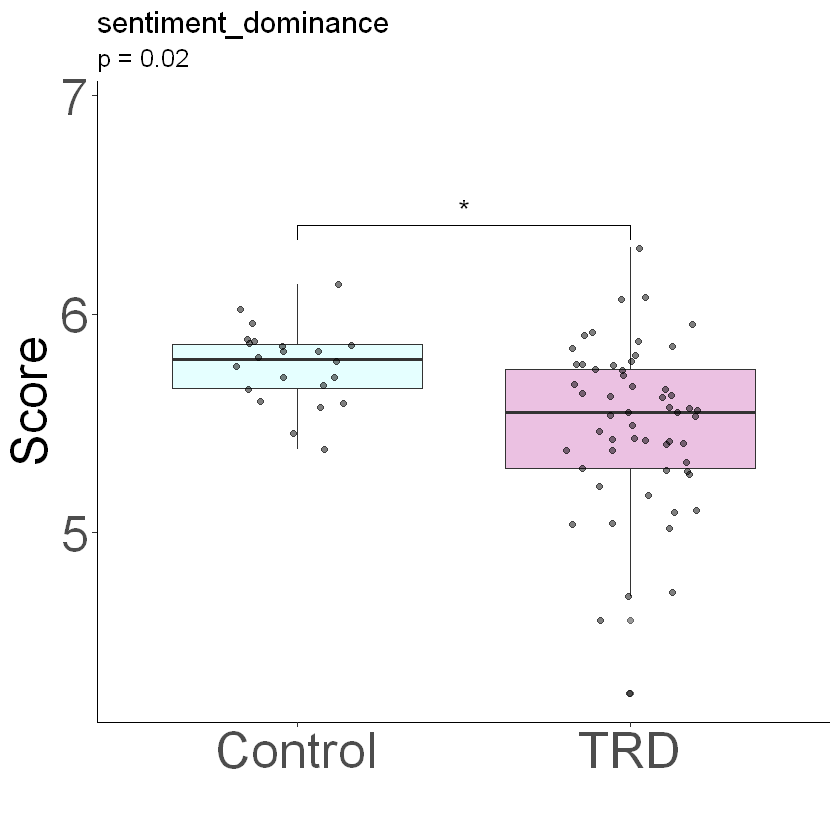

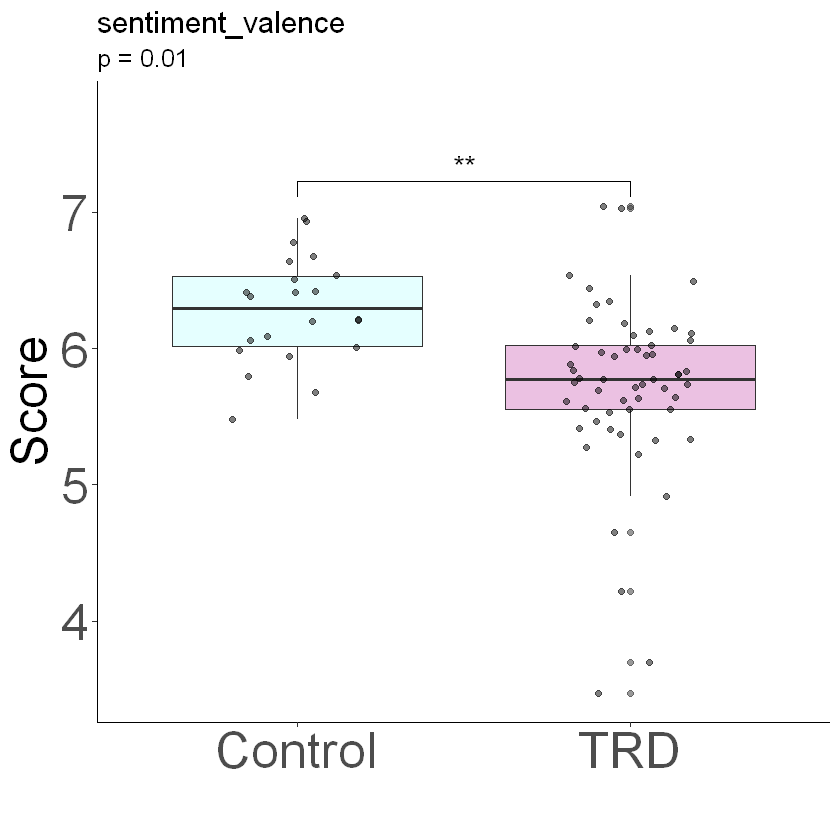

                        Variable   F_Value        Pr_F  Df Partial_Eta_Squared
1     fundamental_frequency_mean 3.1280850 0.081953703 1/1           0.9934268
2 fundamental_frequency_variance 3.3391805 0.072540795 1/1           0.3823835
3              intensity_mean_db 0.8754557 0.353138838 1/1           0.1326290
4          medium_pause_duration 2.5183644 0.117697847 1/1           0.7073400
5                    speech_rate 6.2737572 0.014941683 1/1           0.9347577
6            sentiment_dominance 5.6619936 0.020479413 1/1           0.8513707
7              sentiment_valence 7.1441951 0.009634575 1/1           0.8879444
8              sentiment_arousal 3.5695297 0.063604420 1/1           0.7604050
      Mean_MDD       SD_MDD Mean_Control   SD_Control
1  137.7174595   37.0675174  171.6877246   36.7699026
2 3583.2062040 3530.9992663 3248.1404111 2299.3665951
3   54.5524199    5.1269358   55.8806789    7.4728731
4    0.4005456    0.1978997    0.2782126    0.1962421
5   96.9619358   48

list()

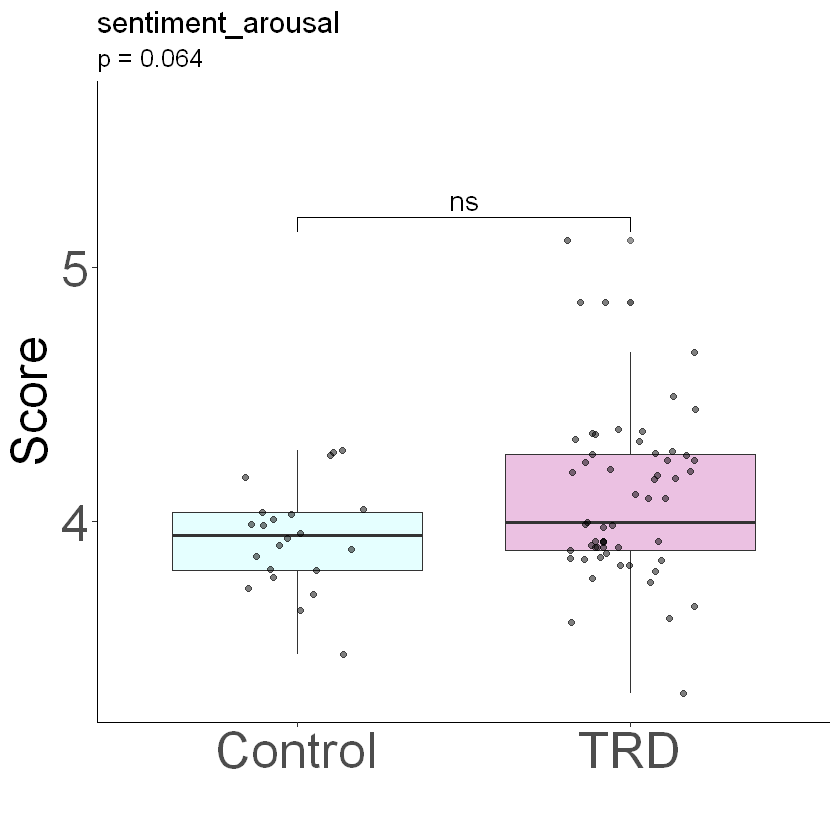

In [20]:
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

covariates <- c("sex", "age_learned_english", "age_screening", "testing_location")

# Initialize lists and data frames
plots <- list()
results_ancova <- list()
# Extend the dataframe to include mean and SD for each group
ancova_stats_df <- data.frame(Variable = character(),
                              F_Value = numeric(),
                              Pr_F = numeric(),
                              Df = numeric(),
                              Partial_Eta_Squared = numeric(),
                              Mean_MDD = numeric(),
                              SD_MDD = numeric(),
                              Mean_Control = numeric(),
                              SD_Control = numeric(),
                              stringsAsFactors = FALSE)

# Filter your data
WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

p_values_ancovas <- c()

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    formula <- as.formula(paste(s, "~ participant_group +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)
    
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova
    
    p_value <- ancova$`Pr(>F)`[2]
    f_value <- ancova$`F`[2]
    df1 <- ancova$`Df`[1]
    df2 <- ancova$`Df`[2]
    ss_effect <- ancova$`Sum Sq`[2]
    ss_error <- ancova$`Sum Sq`[6]
    partial_eta_squared <- ss_effect / (ss_effect + ss_error)
    
    # Calculate mean and SD for each group
    group_stats <- filtered_data %>%
                   group_by(participant_group) %>%
                   summarise(Mean = mean(get(s), na.rm = TRUE), 
                             SD = sd(get(s), na.rm = TRUE)) %>%
                   arrange(participant_group) # Ensure groups are in the same order
    
    # Append the calculated statistics
    ancova_stats_df <- rbind(ancova_stats_df, data.frame(Variable = s, 
                                                         F_Value = f_value, 
                                                         Pr_F = p_value, 
                                                         Df = paste(df1, df2, sep = "/"),
                                                         Partial_Eta_Squared = partial_eta_squared,
                                                         Mean_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$Mean[group_stats$participant_group == "MDD"], NA),
                                                         SD_MDD = ifelse(any(group_stats$participant_group == "MDD"), group_stats$SD[group_stats$participant_group == "MDD"], NA),
                                                         Mean_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$Mean[group_stats$participant_group == "Control"], NA),
                                                         SD_Control = ifelse(any(group_stats$participant_group == "Control"), group_stats$SD[group_stats$participant_group == "Control"], NA)))
    
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    signif_level <- ifelse(p_value < 0.001, '***', 
                  ifelse(p_value < 0.01, '**', 
                  ifelse(p_value < 0.05, '*', 'ns')))

    
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
  # Create and display the plot
 upper_limit <- max(filtered_data[[s]], na.rm = TRUE) * 1.1 # Adjust the multiplier as needed

# Change levels of participant_group from "MDD" to "TRD"
filtered_data$participant_group <- factor(filtered_data$participant_group, levels = c("Control", "MDD"))
levels(filtered_data$participant_group)[levels(filtered_data$participant_group) == "MDD"] <- "TRD"

# Now create the plot
bxp <- ggplot(filtered_data, aes(x = participant_group, y = .data[[s]], fill = participant_group)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.5) +
  geom_jitter(width = 0.2, alpha = 0.5) +
  labs(title = s, x = "", y = "Score", subtitle = paste0("p = ", round(p_value, 3))) +
  theme_classic() +
  theme(axis.title.x = element_text(size = 30), axis.text.x = element_text(size = 30),
        axis.title.y = element_text(size = 30), axis.text.y = element_text(size = 30), title = element_text(size = 15)) +
  scale_fill_manual(values = c("Control" = "#CCFFFF", "TRD" = "#D783C6")) +
  theme(legend.position = "none") +
  geom_signif(comparisons = list(c("Control", "TRD")), annotations = signif_level, map_signif_level = FALSE, textsize = 6) +
  scale_y_continuous(limits = c(NA, upper_limit))

print(bxp)




    p_values_ancovas <- c(p_values_ancovas, p_value)
}

# Print the ANCOVA statistics dataframe and p-values vector
print(ancova_stats_df)
print(p_values_ancovas)

# Print results and display plots
print(results_ancova)
lapply(names(plots), function(x) print(plots[[x]]))

# Save the summary statistics dataframe
write.csv(ancova_stats_df, "SOBP_ANCOVA_summary_statistics.csv", row.names = FALSE)



Correction for multiple comparisons

In [15]:
p_values_ancovas <- ancova_stats_df$Pr_F
adjusted_p_values <- p.adjust(p_values_ancovas, method="BH")
# Display the original and adjusted p-values
data.frame(Original_P_Value = p_values_ancovas, Adjusted_P_Value = adjusted_p_values)

Original_P_Value,Adjusted_P_Value
<dbl>,<dbl>
0.055852272,0.07446970
0.291014804,0.33258835
0.902101954,0.90210195
0.043888383,0.07022141
0.004913549,0.03930839
0.033780784,0.06756157
0.015046050,0.05288085
0.019830319,0.05288085


ANCOVAS with interaction term

In [ ]:
covariates <- c("age_learned_english", "age_screening")  # Removed 'sex' as it will be used in the interaction term
plots <- list()
results_ancova <- list()

WL_jou_bl_feeling <- WL_full_jou_bl %>% filter(stimulus_filename == "en_instruction_journal_feeling.mp3")

for (s in speech_variables) {
    # Filter out data without an assigned participant group
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]

    # Fit the linear model on the filtered data with interaction term
    formula <- as.formula(paste(s, "~ participant_group * sex +", paste(covariates, collapse = " + ")))
    model <- lm(formula, data = filtered_data)

    # Perform ANCOVA
    ancova <- Anova(model, type = "III")
    results_ancova[[s]] <- ancova

    # Extract p-value for participant_group effect
    p_value <- ancova$`Pr(>F)`[2]  # Assuming participant_group is the second term in the model

    # Formatting p-value for the plot
    p_label <- ifelse(is.na(p_value), "p = NA", paste("p =", round(p_value, 5)))

    # Plotting
    plot_name <- paste(s, "ANCOVA_plot", sep = "_")
    plot <- ggplot(filtered_data, aes_string(x = "participant_group", y = s, fill = "participant_group")) +
            geom_boxplot() +
            labs(title = paste("ANCOVA of", s, "by Participant Group"),
                 subtitle = p_label,
                 x = "Participant Group", y = s) +
            theme_minimal() +
            scale_fill_manual(values = c("#CCFFFF", "#D783C6")) +
            theme(legend.position = "none")

    # Save the plot
    plots[[plot_name]] <- plot
}

# Print results and display plots
print(results_ancova)
print(plots)


Sample size

In [38]:
library(dplyr)

# Calculate mean and SD of age for each participant group
age_stats <- WL_jou_bl_feeling %>%
  group_by(participant_group) %>%
  summarise(
    mean_age = mean(age_screening, na.rm = TRUE),
    sd_age = sd(age_screening, na.rm = TRUE)
  )

# Calculate percentage of M and F in each participant group
sex_distribution <- WL_jou_bl_feeling %>%
  group_by(participant_group, sex) %>%
  summarise(
    count = n(),
    .groups = 'drop'
  ) %>%
  mutate(
    percentage = count / sum(count) * 100
  )

# Adjusting previous code for unique IDs and NA participants
# Count unique IDs for each combination of sex and participant group
unique_counts <- WL_jou_bl_feeling %>%
  group_by(participant_group, sex) %>%
  summarise(unique_ids = n_distinct(participant_external_id), .groups = 'drop')

# Filter rows where both sex and participant_group are NA
na_participants <- WL_jou_bl_feeling %>%
  filter(is.na(sex) | is.na(participant_group)) %>%
  distinct(participant_external_id)


# Adjusted code to classify and count IDs by prefix
unique_counts <- WL_jou_bl_feeling %>%
  mutate(prefix = case_when(
    substr(participant_external_id, 1, 3) == "TMS" ~ "TMS",
    substr(participant_external_id, 1, 3) == "MDD" ~ "MDD",
    substr(participant_external_id, 1, 3) == "MFB" ~ "MFB",
    TRUE ~ "Other"  # Handles cases that do not match the above prefixes
  )) %>%
  group_by(participant_group, sex, prefix) %>%
  summarise(unique_ids = n_distinct(participant_external_id), .groups = 'drop')


# Print the results
print(age_stats)
print(sex_distribution)
print(unique_counts)
print(na_participants)


# A tibble: 2 × 3
  participant_group mean_age sd_age
  <fct>                <dbl>  <dbl>
1 Control               47.3   19.0
2 MDD                   44.5   15.1
# A tibble: 4 × 4
  participant_group sex   count percentage
  <fct>             <fct> <int>      <dbl>
1 Control           F        17      21.5 
2 Control           M         5       6.33
3 MDD               F        25      31.6 
4 MDD               M        32      40.5 
# A tibble: 7 × 4
  participant_group sex   prefix unique_ids
  <fct>             <fct> <chr>       <int>
1 Control           F     Other          17
2 Control           M     Other           5
3 MDD               F     MDD             1
4 MDD               F     MFB             1
5 MDD               F     TMS            22
6 MDD               M     MDD             3
7 MDD               M     TMS            29
# A tibble: 0 × 1
# ℹ 1 variable: participant_external_id <chr>


In [12]:
mean(WL_jou_bl_feeling$hamd17_total_pre, na.rm = TRUE)
sd(WL_jou_bl_feeling$hamd17_total_pre, na.rm = TRUE)

WL_jou_bl_feeling_ctls <-WL_jou_bl_feeling %>% filter(participant_group == "Control")
mean(WL_jou_bl_feeling_ctls$qids_total_pre, na.rm = TRUE)
sd(WL_jou_bl_feeling_ctls$qids_total_pre, na.rm = TRUE)

[1] 21

[1] 4.433266

[1] 2.727273

[1] 1.38639

In [29]:
# Filter the dataframe for the MDD group and male sex
mdd_male_df <- WL_jou_bl_feeling %>% 
               filter(participant_group == "MDD", sex == "M")

# Calculate age statistics
age_range <- range(mdd_male_df$age_screening, na.rm = TRUE)
age_mean <- mean(mdd_male_df$age_screening, na.rm = TRUE)
age_median <- median(mdd_male_df$age_screening, na.rm = TRUE)

# Print the results
print(paste("Age range: ", age_range[1], "to", age_range[2]))
print(paste("Mean age: ", age_mean))
print(paste("Median age: ", age_median))

[1] "Age range:  24 to 75"
[1] "Mean age:  48.34375"
[1] "Median age:  49.5"


In [19]:
# Initialize a data frame to store the t-test results outside the loop
t_test_results_df <- data.frame(
  Variable = character(),
  Estimate1 = numeric(),
  Estimate2 = numeric(),
  P_Value = numeric(),
  CI_Lower = numeric(),
  CI_Upper = numeric(),
  stringsAsFactors = FALSE
)

# Loop through each speech variable
for (s in speech_variables) {
    filtered_data <- WL_jou_bl_feeling[!is.na(WL_jou_bl_feeling$participant_group), ]
    
    # Extract data for each location
    data1 <- filtered_data[filtered_data$testing_location == "remote", s, drop = TRUE]
    data2 <- filtered_data[filtered_data$testing_location == "in-person", s, drop = TRUE]

    # Perform the t-test
    t_test_result <- t.test(data1, data2, var.equal = TRUE)  # Assuming equal variances, adjust if needed

    # Append the results to the results data frame
    t_test_results_df <- rbind(t_test_results_df, data.frame(
      Variable = s,
      Estimate1 = mean(data1, na.rm = TRUE),
      Estimate2 = mean(data2, na.rm = TRUE),
      P_Value = t_test_result$p.value,
      CI_Lower = t_test_result$conf.int[1],
      CI_Upper = t_test_result$conf.int[2]
    ))
}

# Print the results
print(t_test_results_df)


                        Variable    Estimate1    Estimate2     P_Value
1     fundamental_frequency_mean  151.2597775  144.0931711 0.431834173
2 fundamental_frequency_variance 4205.4605992 2949.2484956 0.086480422
3              intensity_mean_db   54.2672687   55.4172386 0.390743653
4          medium_pause_duration    0.3044308    0.4133585 0.017665567
5                    speech_rate  126.9173222   97.2811264 0.008665897
6            sentiment_dominance    5.5946306    5.5441025 0.534650283
7              sentiment_valence    5.9628038    5.8202859 0.319518091
8              sentiment_arousal    3.9794253    4.0981729 0.082399962
      CI_Lower      CI_Upper
1  -10.8926462   25.22585898
2 -184.3196193 2696.74382649
3   -3.8029526    1.50301267
4   -0.1983837   -0.01947157
5    7.7295934   51.54279816
6   -0.1107834    0.21183958
7   -0.1407263    0.42576210
8   -0.2531072    0.01561204
